<a href="https://colab.research.google.com/github/Fernanda-a/Brain-Computational-Schools_dated/blob/main/tudo_funcionando_legauu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Problem analisys
### ~r = -u/r^3*~r <- Gravitational force
### Transform into EDOs

In [ ]:
### Parâmetros iniciais

In [ ]:
!pip install git+https://github.com/SWxTREC/pymsis.git


  Cloning https://github.com/SWxTREC/pymsis.git to /tmp/pip-req-build-35muy1gl
  Running command git clone --filter=blob:none --quiet https://github.com/SWxTREC/pymsis.git /tmp/pip-req-build-35muy1gl
  Resolved https://github.com/SWxTREC/pymsis.git to commit 320dd991b2c875ab0dc03d94d1acf676b994aa8f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pymsis: filename=pymsis-0.11.0.dev22+g320dd99-cp311-cp311-linux_x86_64.whl size=279089 sha256=b13e5679ab4305d5f81597a2bd35c0d45dc3348b088a367485d551aa4d86afb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-xrp3de6i/wheels/a1/44/47/31e6edb91788ae0aab350e9a421bbc8f85051bb3f980eb7c60
Successfully built pymsis


In [ ]:
!pip show pymsis


Name: pymsis
Version: 0.11.0.dev22+g320dd99
Summary: A Python wrapper around the NRLMSIS model.
Home-page: https://swxtrec.github.io/pymsis/
Author: 
Author-email: Greg Lucas <greg.lucas@lasp.colorado.edu>
License: MIT License

 Copyright (c) 2020, Regents of the University of Colorado

 Permission is hereby granted, free of charge, to any person obtaining a copy
 of this software and associated documentation files (the "Software"), to deal
 in the Software without restriction, including without limitation the rights
 to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 copies of the Software, and to permit persons to whom the Software is
 furnished to do so, subject to the following conditions:

 The above copyright notice and this permission notice shall be included in all
 copies or substantial portions of the Software.

 THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTA

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 42.4 MB/s eta 0:00:00


In [ ]:
#atual
from pymsis import msis
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt

from astropy.coordinates import get_sun
from astropy.time import Time


In [ ]:
def get_density_msis(t, r_eci, R_terra):

    print("vai tomar no cu")
    from pymsis import calculate
    import numpy as np
    from datetime import datetime, timedelta

    try:
        # Conversões
        r_ecef = eci_to_ecef(r_eci, t)
        lat, lon, alt = ecef_to_lla(r_ecef)
        alt_km = alt / 1000.0
        time = datetime(2025, 1, 1) + timedelta(seconds=t)

        # Segurança contra NaNs
        if not all(np.isfinite([alt_km, lat, lon])):
            print(f"t = {t}, lat = {lat}, lon = {lon}, alt = {alt}")
            print(f"⚠️ Entrada inválida para MSIS (NaN ou inf detectado em t={t:.2f}). Usando rho = 0.")
            return 0.0

        # Prepara arrays corretamente
        dates = np.array([np.datetime64(time)])
        lats = np.array([lat])
        lons = np.array([lon])
        alts = np.array([alt_km])

        # ✅ DEBUG INFO


        # Chamada ao modelo
        output = calculate(
            dates=dates,
            lats=lats,
            lons=lons,
            alts=alts,
            geomagnetic_activity=-1
        )

        # Verificação do shape de saída
        print(f"t = {t}, lat = {lat}, lon = {lon}, alt = {alt}")
        print(f"→ Output shape: {output.shape}, densidade: {output[0, 0]:.3e} kg/m³")

        return float(output[0, 0])

    except Exception as e:


        time = datetime(2025, 1, 1) + timedelta(seconds=t)

        # Conversões de coordenadas
        r_ecef = eci_to_ecef(r_eci, t)
        lat, lon, alt = ecef_to_lla(r_ecef)
        alt_km = alt / 1000.0


        print(f"❌ Erro ao rodar MSIS (t={t:.2f} s): {e}")
        print(f"\n--- MSIS DEBUG @ t={t:.2f} s ---")
        print(f"→ Time: {time}")
        print(f"→ Lat: {lat:.6f}°, Lon: {lon:.6f}°, Alt: {alt:.2f} m ({alt_km:.3f} km)")
        print(f"→ Shape dos inputs: dates={dates.shape}, lats={lats.shape}, lons={lons.shape}, alts={alts.shape}")
        return 0.0


In [ ]:
#atual
def quaternion_to_dcm(q):
    q0, q1, q2, q3 = q
    return np.array([
        [1 - 2*(q2**2 + q3**2),     2*(q1*q2 - q0*q3),     2*(q1*q3 + q0*q2)],
        [    2*(q1*q2 + q0*q3), 1 - 2*(q1**2 + q3**2),     2*(q2*q3 - q0*q1)],
        [    2*(q1*q3 - q0*q2),     2*(q2*q3 + q0*q1), 1 - 2*(q1**2 + q2**2)]
    ])

# --- Torque Gravitacional ---
def torque_gravitacional(q, r_eci, I):
    C_bi = quaternion_to_dcm(q).T  # ECI -> body
    r_body = C_bi @ r_eci
    r_norm = np.linalg.norm(r_body)
    factor = 3 * mu / r_norm**5
    return factor * np.cross(r_body, I @ r_body)

# --- Torque Aerodinâmico ---
def torque_aero(q, v_rel_eci, rho, Cd, A, r_cp_body):
    C_bi = quaternion_to_dcm(q).T
    v_rel_body = C_bi @ v_rel_eci
    F_aero_body = -0.5 * rho * Cd * A * np.linalg.norm(v_rel_body) * v_rel_body
    return np.cross(r_cp_body, F_aero_body)

# --- Torque Radiação Solar ---
def torque_srp(q, r_sat_eci, r_sun_eci, A_srp, r_srp_body):
    P_srp = 4.5e-6  # N/m²
    s_hat = (r_sat_eci - r_sun_eci) / np.linalg.norm(r_sat_eci - r_sun_eci)
    C_bi = quaternion_to_dcm(q).T
    s_body = C_bi @ s_hat
    F_srp_body = -P_srp * A_srp * s_body
    return np.cross(r_srp_body, F_srp_body)

def torque_controle(q, w):
    Kp = 0.1
    Kd = 0.05
    q_desired = np.array([1, 0, 0, 0])
    return -Kp*(q[1:4] - q_desired[1:4]) - Kd*w

# # --- Derivada da atitude ---
# def deriv_attitude(t, y, I, r_eci, v_eci, rho, r_sun_eci):
#     q = y[:4]
#     w = y[4:]

#     tau_gg = torque_gravitacional(q, r_eci, I)

#     # Parâmetros físicos do CubeSat
#     r_cp_body = np.array([0.01, 0, 0])
#     r_srp_body = np.array([0.01, 0, 0])
#     Cd = 2.2
#     A = 0.01
#     A_srp = 0.01

#     tau_aero = torque_aero(q, v_eci, rho, Cd, A, r_cp_body)
#     tau_srp = torque_srp(q, r_eci, r_sun_eci, A_srp, r_srp_body)

#     tau_total = tau_gg + tau_aero + tau_srp

#     w_dot = np.linalg.inv(I) @ (tau_total - np.cross(w, I @ w))

#     Omega = np.array([
#         [0, -w[0], -w[1], -w[2]],
#         [w[0], 0, w[2], -w[1]],
#         [w[1], -w[2], 0, w[0]],
#         [w[2], w[1], -w[0], 0]
#     ])
#     q_dot = 0.5 * Omega @ q

#     return np.concatenate((q_dot, w_dot))

In [ ]:
#atual
from astropy.coordinates import get_sun, ICRS
from astropy.time import Time
from astropy import units as u

def get_sun_position(t):
    """Calcula a posição do Sol em coordenadas ECI cartesianas (metros) usando Astropy.

    Args:
        t (float): Tempo desde a época inicial em segundos

    Returns:
        np.ndarray: Vetor posição do Sol no sistema ECI [x, y, z] em metros
    """


    # Epoch handling (cache this if calling frequently)
    epoch = Time("2025-01-01 00:00:00", scale='utc') + t * u.second

    # Get Sun position in ICRS (already in Cartesian coordinates)
    sun_pos = get_sun(epoch).transform_to(ICRS)


    # Convert to Cartesian vector in meters
    return np.array([
        sun_pos.cartesian.x.value * sun_pos.distance.value,
        sun_pos.cartesian.y.value * sun_pos.distance.value,
        sun_pos.cartesian.z.value * sun_pos.distance.value
    ]) * 1.496e11  # Convert AU to meters


In [ ]:
#atual
### Versao com um pouquinho de atitude

from pymsis import msis
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt

# Constantes
G = 6.67430e-11          # Constante gravitacional (m^3 kg^-1 s^-2)
M_terra = 5.972e24       # Massa da Terra (kg)
mu = G * M_terra         # Parâmetro gravitacional da Terra (m^3/s^2)
R_terra = 6371e3         # Raio médio da Terra (m)
J2 = 1.08263e-3          # Coeficiente J2
Cd = 2.2                 # Coeficiente de arrasto
A = 0.01                 # Área frontal (m²)
m = 1.0                  # Massa do satélite (kg)
rho0 = 1.225             # Densidade ao nível do mar (kg/m³)

#------


# Inércia (Adicionado, pois é usado em deriv)
Ixx = Iyy = Izz = 2.72296295e-3  # kg.m^2 (convertido de g.mm^2)
IB = np.diag([Ixx, Iyy, Izz])

# Parâmetros orbitais
T = 90 * 60              # Período orbital (s)
#e = 0.0167
#i = np.radians(50)
e = 0
i = np.radians(20)
RAAN = np.radians(65)
omega = np.radians(100)

altitude_inicial = 478e3

# Cálculo do semi-eixo maior
a = (mu * (T / (2 * np.pi))**2)**(1 / 3)
#r0 = a * (1 - e)
r0 = altitude_inicial + R_terra
v0 = np.sqrt(mu * (1 + e) / r0)

# Estado inicial em coordenadas perifocais
r_perifocal = np.array([r0, 0, 0])
v_perifocal = np.array([0, v0, 0])

# Matrizes de rotação
def Rz(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])

def Rx(theta):
    return np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta),  np.cos(theta)]
    ])

# Transformação para ECI
Q_pX = Rz(-RAAN) @ Rx(-i) @ Rz(-omega)
r0_eci = Q_pX @ r_perifocal
v0_eci = Q_pX @ v_perifocal

F_drag_body_hist = []
torque_body_hist = []

def eci_to_ecef(r_eci, t, omega_terra=7.2921150e-5):
    """Converte coordenadas ECI para ECEF, considerando a rotação da Terra."""
    theta = omega_terra * t
    Rz_theta = np.array([
        [np.cos(theta), np.sin(theta), 0],
        [-np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return Rz_theta @ r_eci

def ecef_to_lla(r_ecef):
    """Converte ECEF para latitude, longitude e altitude."""
    x, y, z = r_ecef
    longitude = np.arctan2(y, x)
    latitude = np.arctan2(z, np.sqrt(x**2 + y**2))
    altitude = np.linalg.norm(r_ecef) - R_terra
    return np.degrees(latitude), np.degrees(longitude), altitude

# Função com J2 e arrasto (agora inclui dinâmica de atitude)
def skew(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])

def omega_matrix(w):
    """Matriz para multiplicação com o quaternion."""
    wx, wy, wz = w
    return np.array([
        [0, -wx, -wy, -wz],
        [wx, 0, wz, -wy],
        [wy, -wz, 0, wx],
        [wz, wy, -wx, 0]
    ])

# Re-import quaternion_to_dcm if it's in a separate cell
# from the_cell_where_quaternion_to_dcm_is_defined import quaternion_to_dcm
# Assuming it's in the same script or already defined earlier.
# Make sure quaternion_to_dcm is accessible here.

def deriv(t, y):
    r = y[0:3]
    v = y[3:6]
    q = y[6:10]  # Now correctly slicing for the quaternion
    w = y[10:13] # And angular velocity

    r_norm = np.linalg.norm(r)
    r2 = r_norm**2
    z2 = r[2]**2

    # -----------------------------
    # 1. Aceleração orbital (grav + J2 + arrasto)
    # -----------------------------
    rx, ry, rz = r
    factor = -mu / r_norm**3
    ax = factor * rx * (1 - (3/2)*J2*(R_terra**2/r2)*(5*z2/r2 - 1))
    ay = factor * ry * (1 - (3/2)*J2*(R_terra**2/r2)*(5*z2/r2 - 1))
    az = factor * rz * (1 - (3/2)*J2*(R_terra**2/r2)*(5*z2/r2 - 3))
    a_grav_j2 = np.array([ax, ay, az])

    # Atmosfera

    rho = get_density_msis(t, r, R_terra)
    if (not rho):
      altitude = r_norm - R_terra
      # Placeholder for MSIS density - still using simplified for now
      rho = rho0 * np.exp(-altitude / H)
    # For MSIS, you would need the date and ECEF coords, which adds complexity
    # r_ecef = eci_to_ecef(r, t)
    # lat, lon, alt = ecef_to_lla(r_ecef) # Note ecef_to_lla returns alt wrt R_terra
    # time = datetime(2025, 1, 1) + timedelta(seconds=t)
    # try:
    #     output = msis.run([time], [alt/1000], [lat], [lon], [f107], [f107a], [ap])
    #     rho = output[0,0,0,0,3] # Accessing density from MSIS output
    # except Exception as e:
    #     print(f"MSIS error at t={t}, alt={alt}: {e}")
    #     rho = 0 # Or handle error appropriately

    # Relative velocity wrt rotating atmosphere (approximate - atmosphere velocity isn't just omega_terra cross r)
    # A more accurate model would consider atmospheric co-rotation varying with altitude.
    v_atm = np.cross(np.array([0, 0, 7.2921150e-5]), r) # Approximate atmospheric velocity
    v_rel = v - v_atm
    v_rel_norm = np.linalg.norm(v_rel)

    # Área frontal depende da atitude!
    # Transformar v_rel para o referencial do corpo
    # Ensure quaternion_to_dcm function is defined or imported here
    C_BI = quaternion_to_dcm(q) # This call now receives the correct q
    v_rel_body = C_BI @ v_rel
    v_unit = v_rel_body / (np.linalg.norm(v_rel_body) + 1e-10)

    # Área efetiva: considering faces ortogonais de um cubo
    A_faces = [A, A, A] # Assuming A is the area of one face if cube is aligned
    # A_proj is the projected area onto the plane perpendicular to v_rel_body
    A_proj = (
        A_faces[0] * abs(v_unit[0]) + # Area projected onto y-z plane (normal in x)
        A_faces[1] * abs(v_unit[1]) + # Area projected onto x-z plane (normal in y)
        A_faces[2] * abs(v_unit[2])   # Area projected onto x-y plane (normal in z)
    )

    a_drag = -0.5 * rho * Cd * A_proj / m * v_rel_norm * v_rel

    a_total = a_grav_j2 + a_drag

    # -----------------------------
    # 2. Dinâmica de atitude
    # -----------------------------
    # Torque aerodinâmico aproximado: vetor de arrasto x deslocamento do centro de pressão
    # Assuming a cube of side L, center of pressure might be offset
    L = 0.1  # comprimento lateral do cubo (m)
    r_cp = np.array([0.01, 0, 0])  # deslocamento do centro de pressão em body (pode ser 1 cm da frente)
    # F_drag_body is the drag force vector in the body frame
    F_drag_body = -0.5 * rho * Cd * A_proj * v_rel_norm * v_rel_body # Force in body frame
    torque_aero_body = np.cross(r_cp, F_drag_body) # Torque in body frame

    # Add other torques here (Gravity Gradient, Solar Radiation Pressure, Control)
    # Ensure I is defined (using IB as defined globally)
    # tau_gg = torque_gravitacional(q, r, IB) # Needs r_eci, I
    # tau_srp = torque_srp(q, r, r_sun_eci, A_srp, r_srp_body) # Needs r_sat_eci, r_sun_eci, A_srp, r_srp_body
    # tau_control = torque_controle(q, w) # Needs q, w

    # Combine torques (example: only aero torque for now)
    torque_total_body = torque_aero_body

    F_drag_body_hist.append(F_drag_body)
    torque_body_hist.append(torque_total_body)
    # Derivada da velocidade angular (Euler)
    # Ensure I is defined (using IB as defined globally)
    I = IB
    I_inv = np.linalg.inv(I)
    dw_dt = I_inv @ (torque_total_body - np.cross(w, I @ w))

    # Derivada do quaternion
    dq_dt = 0.5 * omega_matrix(w) @ q
    dq_dt = dq_dt / (np.linalg.norm(dq_dt) + 1e-10)

    # -----------------------------
    # Saída: concatenar derivadas
    # -----------------------------
    # The output must match the order of the state vector y: [r, v, q, w]
    return np.concatenate((v, a_total, dq_dt, dw_dt))


# Runge-Kutta de 4ª ordem
def rk4_step(f, t, y, dt):
    # y is the full state vector [r, v, q, w]
    k1 = f(t, y)
    k2 = f(t + dt/2, y + dt*k1/2)
    k3 = f(t + dt/2, y + dt*k2/2)
    k4 = f(t + dt, y + dt*k3)
    return y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Integração
t0 = 0
tf = 12 * 3600  # 12 horas
dt = 10
N = int((tf - t0) / dt)
t_array = np.linspace(t0, tf, N)

# Initial state vector including attitude
q0 = np.array([1.0, 0.0, 0.0, 0.0])   # initial attitude (identity quaternion)
w0 = np.array([0.0, 0.0, 0.0])       # initial angular velocity (rad/s)

y0 = np.concatenate((r0_eci, v0_eci, q0, w0)) # Full initial state

# Initialize state array with size 13
state = np.zeros((N, 13)) # Corrected size for [r, v, q, w]
state[0, :] = y0 # Assign the full initial state

# Initialize array for ECEF coordinates (optional, can calculate on the fly)
r_ecef = np.zeros((N, 3))
r_ecef[0, :] = eci_to_ecef(state[0, :3], t_array[0]) # Calculate initial ECEF

# Store attitude separately for easier plotting/analysis (optional)
attitude_q = np.zeros((N, 4))
attitude_w = np.zeros((N, 3))
attitude_q[0, :] = q0
attitude_w[0, :] = w0


for k in range(1, N):
    # Pass the full state vector from the previous step
    state[k, :] = rk4_step(deriv, t_array[k-1], state[k-1, :], dt)

    # Normalize the quaternion after each step to prevent drift
    q_next = state[k, 6:10]
    q_norm = np.linalg.norm(q_next)
    if q_norm > 1e-6: # Avoid division by zero if q is [0,0,0,0]
        state[k, 6:10] = q_next / q_norm
    else:
        # Handle the case where quaternion norm is near zero (e.g., re-initialize to identity)
        state[k, 6:10] = np.array([1.0, 0.0, 0.0, 0.0])


    # Calculate ECEF position
    r_ecef[k, :] = eci_to_ecef(state[k, :3], t_array[k])

    # Store attitude (optional)
    attitude_q[k, :] = state[k, 6:10]
    attitude_w[k, :] = state[k, 10:13]


# Extract position and velocity after integration
r_eci = state[:, :3]
v_eci = state[:, 3:6]
# attitude_q and attitude_w contain the quaternion and angular velocity history

# Convert final ECEF positions to LLA
lat, lon, alt = np.array([ecef_to_lla(r) for r in r_ecef]).T

# Now you can use r_eci, v_eci, attitude_q, attitude_w, t_array, lat, lon for plotting and analysis

vai tomar no cu


/usr/local/lib/python3.11/dist-packages/pymsis/utils.py:45: UserWarning: Downloading ap and F10.7 data from https://celestrak.org/SpaceData/SW-All.csv
  warnings.warn(f"Downloading ap and F10.7 data from {_F107_AP_URL}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
t = 39034.034498726556, lat = 17.031418023478235, lon = 5.920448524322503, alt = 477220.387459646
→ Output shape: (1, 11), densidade: 3.208e-12 kg/m³
vai tomar no cu
t = 39034.034498726556, lat = 17.031418461325075, lon = 5.9204587113043425, alt = 477007.684531576
→ Output shape: (1, 11), densidade: 3.217e-12 kg/m³
vai tomar no cu
t = 39039.034498726556, lat = 17.090172303652473, lon = 6.227723281091314, alt = 477130.7690795781
→ Output shape: (1, 11), densidade: 3.218e-12 kg/m³
vai tomar no cu
t = 39039.036814077335, lat = 17.090173517631754, lon = 6.227720403497868, alt = 477130.76129059214
→ Output shape: (1, 11), densidade: 3.218e-12 kg/m³
vai tomar no cu
t = 39044.036814077335, lat = 17.148399199046256, lon = 6.535199629569223, alt = 477253.6547440849
→ Output shape: (1, 11), densidade: 3.219e-12 kg/m³
vai tomar no cu
t = 39044.036814077335, lat = 17.14839959543386, lon = 6.5352098289807525, alt = 477040

In [ ]:
#atual
## tenta manter uma  altitude desejada se só quiser evitar a reentrada pode retirar a a_total e colocar Kp multiplicando o thusth
### Versao com um pouquinho de atitude

from pymsis import msis
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt

# Constantes
G = 6.67430e-11          # Constante gravitacional (m^3 kg^-1 s^-2)
M_terra = 5.972e24       # Massa da Terra (kg)
mu = G * M_terra         # Parâmetro gravitacional da Terra (m^3/s^2)
R_terra = 6371e3         # Raio médio da Terra (m)
J2 = 1.08263e-3          # Coeficiente J2
Cd = 2.2                 # Coeficiente de arrasto
A = 0.01                 # Área frontal (m²)
m = 1.0                  # Massa do satélite (kg)
rho0 = 1.225             # Densidade ao nível do mar (kg/m³)
H = 8500.0               # Altura de escala da atmosfera (m)

altitude_target = 300e3  # Altitude desejada (ex: 400 km)
tolerance = 10e3         # Tolerância (ex: 10 km)
thrust_magnitude = 0.01


# Inércia (Adicionado, pois é usado em deriv)
Ixx = Iyy = Izz = 2.72296295e-3  # kg.m^2 (convertido de g.mm^2)
IB = np.diag([Ixx, Iyy, Izz])

# Parâmetros orbitais
T = 90 * 60              # Período orbital (s)
e = 0.0167
i = np.radians(50)
RAAN = np.radians(65)
omega = np.radians(100)

# Cálculo do semi-eixo maior
a = (mu * (T / (2 * np.pi))**2)**(1 / 3)
r0 = a * (1 - e)
v0 = np.sqrt(mu * (1 + e) / r0)

# Estado inicial em coordenadas perifocais
r_perifocal = np.array([r0, 0, 0])
v_perifocal = np.array([0, v0, 0])

# Matrizes de rotação
def Rz(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])

def Rx(theta):
    return np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta),  np.cos(theta)]
    ])

# Transformação para ECI
Q_pX = Rz(-RAAN) @ Rx(-i) @ Rz(-omega)
r0_eci = Q_pX @ r_perifocal
v0_eci = Q_pX @ v_perifocal

F_drag_body_hist = []
torque_body_hist = []

def eci_to_ecef(r_eci, t, omega_terra=7.2921150e-5):
    """Converte coordenadas ECI para ECEF, considerando a rotação da Terra."""
    theta = omega_terra * t
    Rz_theta = np.array([
        [np.cos(theta), np.sin(theta), 0],
        [-np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return Rz_theta @ r_eci

def ecef_to_lla(r_ecef):
    """Converte ECEF para latitude, longitude e altitude."""
    x, y, z = r_ecef
    longitude = np.arctan2(y, x)
    latitude = np.arctan2(z, np.sqrt(x**2 + y**2))
    altitude = np.linalg.norm(r_ecef) - R_terra
    return np.degrees(latitude), np.degrees(longitude), altitude

# Função com J2 e arrasto (agora inclui dinâmica de atitude)
def skew(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])

def omega_matrix(w):
    """Matriz para multiplicação com o quaternion."""
    wx, wy, wz = w
    return np.array([
        [0, -wx, -wy, -wz],
        [wx, 0, wz, -wy],
        [wy, -wz, 0, wx],
        [wz, wy, -wx, 0]
    ])

# Re-import quaternion_to_dcm if it's in a separate cell
# from the_cell_where_quaternion_to_dcm_is_defined import quaternion_to_dcm
# Assuming it's in the same script or already defined earlier.
# Make sure quaternion_to_dcm is accessible here.

def deriv(t, y):
    r = y[0:3]
    v = y[3:6]
    q = y[6:10]  # Now correctly slicing for the quaternion
    w = y[10:13] # And angular velocity

    r_norm = np.linalg.norm(r)
    r2 = r_norm**2
    z2 = r[2]**2

    # -----------------------------
    # 1. Aceleração orbital (grav + J2 + arrasto)
    # -----------------------------
    rx, ry, rz = r
    factor = -mu / r_norm**3
    ax = factor * rx * (1 - (3/2)*J2*(R_terra**2/r2)*(5*z2/r2 - 1))
    ay = factor * ry * (1 - (3/2)*J2*(R_terra**2/r2)*(5*z2/r2 - 1))
    az = factor * rz * (1 - (3/2)*J2*(R_terra**2/r2)*(5*z2/r2 - 3))
    a_grav_j2 = np.array([ax, ay, az])

    # Atmosfera

    rho = get_density_msis(t, r, R_terra)
    if (not rho):
      altitude = r_norm - R_terra
      # Placeholder for MSIS density - still using simplified for now
      rho = rho0 * np.exp(-altitude / H)
    # For MSIS, you would need the date and ECEF coords, which adds complexity
    # r_ecef = eci_to_ecef(r, t)
    # lat, lon, alt = ecef_to_lla(r_ecef) # Note ecef_to_lla returns alt wrt R_terra
    # time = datetime(2025, 1, 1) + timedelta(seconds=t)
    # try:
    #     output = msis.run([time], [alt/1000], [lat], [lon], [f107], [f107a], [ap])
    #     rho = output[0,0,0,0,3] # Accessing density from MSIS output
    # except Exception as e:
    #     print(f"MSIS error at t={t}, alt={alt}: {e}")
    #     rho = 0 # Or handle error appropriately

    # Relative velocity wrt rotating atmosphere (approximate - atmosphere velocity isn't just omega_terra cross r)
    # A more accurate model would consider atmospheric co-rotation varying with altitude.
    v_atm = np.cross(np.array([0, 0, 7.2921150e-5]), r) # Approximate atmospheric velocity
    v_rel = v - v_atm
    v_rel_norm = np.linalg.norm(v_rel)

    # Área frontal depende da atitude!
    # Transformar v_rel para o referencial do corpo
    # Ensure quaternion_to_dcm function is defined or imported here
    C_BI = quaternion_to_dcm(q) # This call now receives the correct q
    v_rel_body = C_BI @ v_rel
    v_unit = v_rel_body / (np.linalg.norm(v_rel_body) + 1e-10)

    # Área efetiva: considering faces ortogonais de um cubo
    A_faces = [A, A, A] # Assuming A is the area of one face if cube is aligned
    # A_proj is the projected area onto the plane perpendicular to v_rel_body
    A_proj = (
        A_faces[0] * abs(v_unit[0]) + # Area projected onto y-z plane (normal in x)
        A_faces[1] * abs(v_unit[1]) + # Area projected onto x-z plane (normal in y)
        A_faces[2] * abs(v_unit[2])   # Area projected onto x-y plane (normal in z)
    )

    a_drag = -0.5 * rho * Cd * A_proj / m * v_rel_norm * v_rel

    a_total = a_grav_j2 + a_drag

    ##controle de altitude

    altitude = r_norm - R_terra
    thrust_force = np.zeros(3)
    Kp = 0.06  # ajuste fino
    altitude_error = altitude_target - altitude
    thrust_magnitude = altitude_error

    # saturar
    thrust_magnitude = np.clip(thrust_magnitude, -0.01, 0.01)
    if altitude < altitude_target - tolerance:


        thrust_direction = r / (r_norm + 1e-10)  # Empuxo na direção radial para "subir"
        thrust_force = thrust_magnitude * thrust_direction * -a_total * Kp

    elif altitude > altitude_target + tolerance:
        thrust_direction = -r / (r_norm + 1e-10)  # Empuxo contrário à direção radial para "descer"
        thrust_force = thrust_magnitude * thrust_direction * -a_total * Kp

    a_thrust = thrust_force / m
    a_total += a_thrust

    # -----------------------------
    # 2. Dinâmica de atitude
    # -----------------------------
    # Torque aerodinâmico aproximado: vetor de arrasto x deslocamento do centro de pressão
    # Assuming a cube of side L, center of pressure might be offset
    L = 0.1  # comprimento lateral do cubo (m)
    r_cp = np.array([0.01, 0, 0])  # deslocamento do centro de pressão em body (pode ser 1 cm da frente)
    # F_drag_body is the drag force vector in the body frame
    F_drag_body = -0.5 * rho * Cd * A_proj * v_rel_norm * v_rel_body # Force in body frame
    torque_aero_body = np.cross(r_cp, F_drag_body) # Torque in body frame

    # Add other torques here (Gravity Gradient, Solar Radiation Pressure, Control)
    # Ensure I is defined (using IB as defined globally)
    # tau_gg = torque_gravitacional(q, r, IB) # Needs r_eci, I
    # tau_srp = torque_srp(q, r, r_sun_eci, A_srp, r_srp_body) # Needs r_sat_eci, r_sun_eci, A_srp, r_srp_body
    # tau_control = torque_controle(q, w) # Needs q, w

    # Combine torques (example: only aero torque for now)
    torque_total_body = torque_aero_body

    F_drag_body_hist.append(F_drag_body)
    torque_body_hist.append(torque_total_body)
    # Derivada da velocidade angular (Euler)
    # Ensure I is defined (using IB as defined globally)
    I = IB
    I_inv = np.linalg.inv(I)
    dw_dt = I_inv @ (torque_total_body - np.cross(w, I @ w))

    # Derivada do quaternion
    dq_dt = 0.5 * omega_matrix(w) @ q
    dq_dt = dq_dt / (np.linalg.norm(dq_dt) + 1e-10)

    # -----------------------------
    # Saída: concatenar derivadas
    # -----------------------------
    # The output must match the order of the state vector y: [r, v, q, w]
    return np.concatenate((v, a_total, dq_dt, dw_dt))


# Runge-Kutta de 4ª ordem
def rk4_step(f, t, y, dt):
    # y is the full state vector [r, v, q, w]
    k1 = f(t, y)
    k2 = f(t + dt/2, y + dt*k1/2)
    k3 = f(t + dt/2, y + dt*k2/2)
    k4 = f(t + dt, y + dt*k3)
    return y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Integração
t0 = 0
tf = 12 * 3600  # 12 horas
dt = 10
N = int((tf - t0) / dt)
t_array = np.linspace(t0, tf, N)

# Initial state vector including attitude
q0 = np.array([1.0, 0.0, 0.0, 0.0])   # initial attitude (identity quaternion)
w0 = np.array([0.0, 0.0, 0.0])       # initial angular velocity (rad/s)

y0 = np.concatenate((r0_eci, v0_eci, q0, w0)) # Full initial state

# Initialize state array with size 13
state = np.zeros((N, 13)) # Corrected size for [r, v, q, w]
state[0, :] = y0 # Assign the full initial state

# Initialize array for ECEF coordinates (optional, can calculate on the fly)
r_ecef = np.zeros((N, 3))
r_ecef[0, :] = eci_to_ecef(state[0, :3], t_array[0]) # Calculate initial ECEF

# Store attitude separately for easier plotting/analysis (optional)
attitude_q = np.zeros((N, 4))
attitude_w = np.zeros((N, 3))
attitude_q[0, :] = q0
attitude_w[0, :] = w0


for k in range(1, N):
    # Pass the full state vector from the previous step
    state[k, :] = rk4_step(deriv, t_array[k-1], state[k-1, :], dt)

    # Normalize the quaternion after each step to prevent drift
    q_next = state[k, 6:10]
    q_norm = np.linalg.norm(q_next)
    if q_norm > 1e-6: # Avoid division by zero if q is [0,0,0,0]
        state[k, 6:10] = q_next / q_norm
    else:
        # Handle the case where quaternion norm is near zero (e.g., re-initialize to identity)
        state[k, 6:10] = np.array([1.0, 0.0, 0.0, 0.0])


    # Calculate ECEF position
    r_ecef[k, :] = eci_to_ecef(state[k, :3], t_array[k])

    # Store attitude (optional)
    attitude_q[k, :] = state[k, 6:10]
    attitude_w[k, :] = state[k, 10:13]


# Extract position and velocity after integration
r_eci = state[:, :3]
v_eci = state[:, 3:6]
# attitude_q and attitude_w contain the quaternion and angular velocity history

# Convert final ECEF positions to LLA
lat, lon, alt = np.array([ecef_to_lla(r) for r in r_ecef]).T

# Now you can use r_eci, v_eci, attitude_q, attitude_w, t_array, lat, lon for plotting and analysis

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
t = 39034.034498726556, lat = 9.904512418884806, lon = 121.01992937975072, alt = 267098.7507789014
→ Output shape: (1, 11), densidade: 6.723e-11 kg/m³
vai tomar no cu
t = 39034.034498726556, lat = 9.904502974838064, lon = 121.01993725473119, alt = 266872.1639948208
→ Output shape: (1, 11), densidade: 6.751e-11 kg/m³
vai tomar no cu
t = 39039.034498726556, lat = 9.65084536369308, lon = 121.22028554653987, alt = 267282.68521247804
→ Output shape: (1, 11), densidade: 6.691e-11 kg/m³
vai tomar no cu
t = 39039.036814077335, lat = 9.650839576148819, lon = 121.22028090046672, alt = 267282.6652146233
→ Output shape: (1, 11), densidade: 6.691e-11 kg/m³
vai tomar no cu
t = 39044.036814077335, lat = 9.397054250486674, lon = 121.42028432436219, alt = 267692.8219494978
→ Output shape: (1, 11), densidade: 6.630e-11 kg/m³
vai tomar no cu
t = 39044.036814077335, lat = 9.397044835260898, lon = 121.4202921859155, alt = 267466.

In [ ]:
import pandas as pd

# Criar um DataFrame com os dados
df = pd.DataFrame({
    'tempo_s': t_array,
    'latitude_deg': lat,
    'longitude_deg': lon,
    'altitude_m': alt
})

# Salvar em CSV
df.to_csv('coordenadas_orbita.csv', index=False)

print("✅ Arquivo 'coordenadas_orbita.csv' salvo com sucesso.")


✅ Arquivo 'coordenadas_orbita.csv' salvo com sucesso.


In [ ]:
import pandas as pd
import numpy as np
import pymsis
from datetime import datetime, timedelta

# Carregar os primeiros 20 pontos do arquivo
df = pd.read_csv("coordenadas_orbita.csv").iloc[:20]

# Converter tempo (s) em datetime
datas = np.array([
    np.datetime64("2025-01-01T00:00:00") + np.timedelta64(int(t), "s")
    for t in df["tempo_s"]
])

# Extrair inputs
alts = df["altitude_m"].values / 1000  # metros → km
lats = df["latitude_deg"].values
lons = df["longitude_deg"].values

# Rodar modelo MSIS com os dados (usa F10.7 e ap automaticamente via internet)
output = pymsis.calculate(
    dates=datas,
    lats=lats,
    lons=lons,
    alts=alts,
    geomagnetic_activity=-1  # usa automaticamente dados reais de F10.7 e ap
)

# Adicionar densidade à tabela (output[..., 0] é a densidade total)
df["rho_kg_m3"] = output[:, 0]

# Mostrar resultado
print(df[["tempo_s", "latitude_deg", "longitude_deg", "altitude_m", "rho_kg_m3"]].to_string(index=False))

# (Opcional) Salvar como CSV
df.to_csv("densidades_calculadas.csv", index=False)


   tempo_s  latitude_deg  longitude_deg    altitude_m    rho_kg_m3
  0.000000     48.973539    -170.339814 170396.502016 8.206471e-10
 10.002315     49.108657    -169.350296 170404.833003 8.225673e-10
 20.004631     49.234530    -168.355344 170429.830077 8.239635e-10
 30.006946     49.351068    -167.355303 170471.497094 8.248264e-10
 40.009261     49.458190    -166.350531 170529.835050 8.251593e-10
 50.011577     49.555818    -165.341399 170604.841977 8.249490e-10
 60.013892     49.643881    -164.328292 170696.512934 8.242058e-10
 70.016207     49.722315    -163.311604 170804.840010 8.229249e-10
 80.018523     49.791064    -162.291741 170929.812211 8.211158e-10
 90.020838     49.850076    -161.269118 171071.415729 8.187799e-10
100.023154     49.899308    -160.244157 171229.633538 8.159190e-10
110.025469     49.938725    -159.217290 171404.445653 8.125485e-10
120.027784     49.968298    -158.188951 171595.829025 8.086669e-10
130.030100     49.988007    -157.159582 171803.757568 8.042937

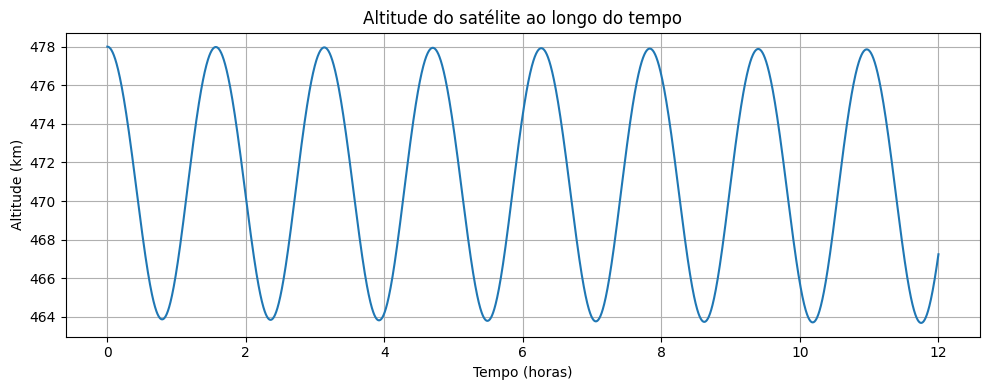

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(t_array / 3600, alt / 1e3)  # tempo em horas, altitude em km
plt.xlabel('Tempo (horas)')
plt.ylabel('Altitude (km)')
plt.title('Altitude do satélite ao longo do tempo')
plt.grid(True)
plt.tight_layout()
plt.show()


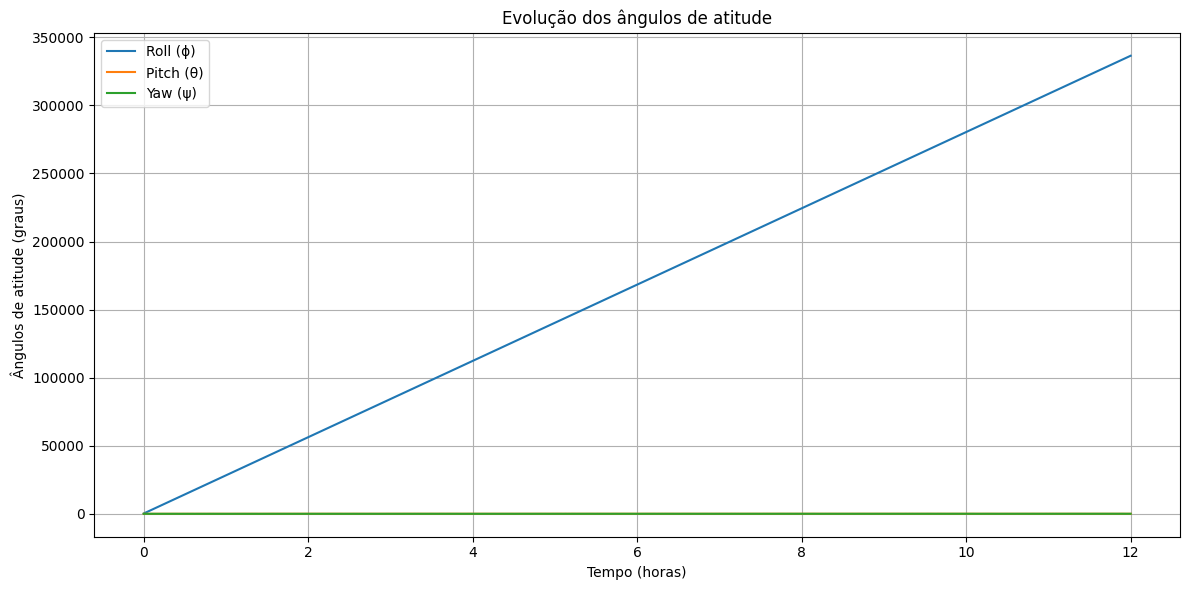

In [ ]:
#atual
from scipy.spatial.transform import Rotation as R

# Converter todos os quaternions para ângulos de Euler
euler_angles = R.from_quat(attitude_q).as_euler('zyx', degrees=True)
yaw = euler_angles[:, 0]
pitch = euler_angles[:, 1]
roll = euler_angles[:, 2]
roll_u  = np.unwrap(np.deg2rad(roll)) * 180/np.pi
pitch_u = np.unwrap(np.deg2rad(pitch)) * 180/np.pi
yaw_u   = np.unwrap(np.deg2rad(yaw)) * 180/np.pi

plt.figure(figsize=(12,6))
plt.plot(t_array / 3600, roll_u, label='Roll (ϕ)')
plt.plot(t_array / 3600, pitch_u, label='Pitch (θ)')
plt.plot(t_array / 3600, yaw_u, label='Yaw (ψ)')
plt.xlabel('Tempo (horas)')
plt.ylabel('Ângulos de atitude (graus)')
plt.title('Evolução dos ângulos de atitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# plt.plot(t_array/3600, attitude_w[:,0])
# plt.xlabel('Tempo (h)')
# plt.ylabel('ωₓ  (rad/s)')
# plt.grid()

# plt.plot(t_array / 3600, attitude_w[:, 1])
# plt.xlabel('Tempo (h)')
# plt.ylabel('ω_y (rad/s)')
# plt.grid(True)


# # Para ω_z
# plt.plot(t_array / 3600, attitude_w[:, 2])
# plt.xlabel('Tempo (h)')
# plt.ylabel('ω_z (rad/s)')
# plt.grid(True)
# plt.show()

In [ ]:
# torque_y = []
# torque_z = []
# for k in range(N):
#     Fx,Fy,Fz = F_drag_body_hist[k]
#     torque_y.append(-0.01*Fz)
#     torque_z.append( 0.01*Fy)
# plt.plot(t_array/3600, torque_z); ...


In [ ]:
# plt.figure(figsize=(8,4))
# plt.plot(t_array/3600, torque_body_hist[:,1], label='τ_y')
# plt.plot(t_array/3600, torque_body_hist[:,2], label='τ_z')
# plt.xlabel('Tempo (h)'); plt.ylabel('N·m')
# plt.legend(); plt.grid(True); plt.tight_layout()
# plt.show()


In [ ]:
# alt_mean = np.mean(alt)

# plt.figure(figsize=(10,4))
# plt.plot(t_array / 3600, alt / 1e3, label='Altitude real')
# plt.axhline(alt_mean / 1e3, color='r', linestyle='--', label='Altitude média')
# plt.xlabel('Tempo (horas)')
# plt.ylabel('Altitude (km)')
# plt.title('Altitude do satélite ao longo do tempo')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


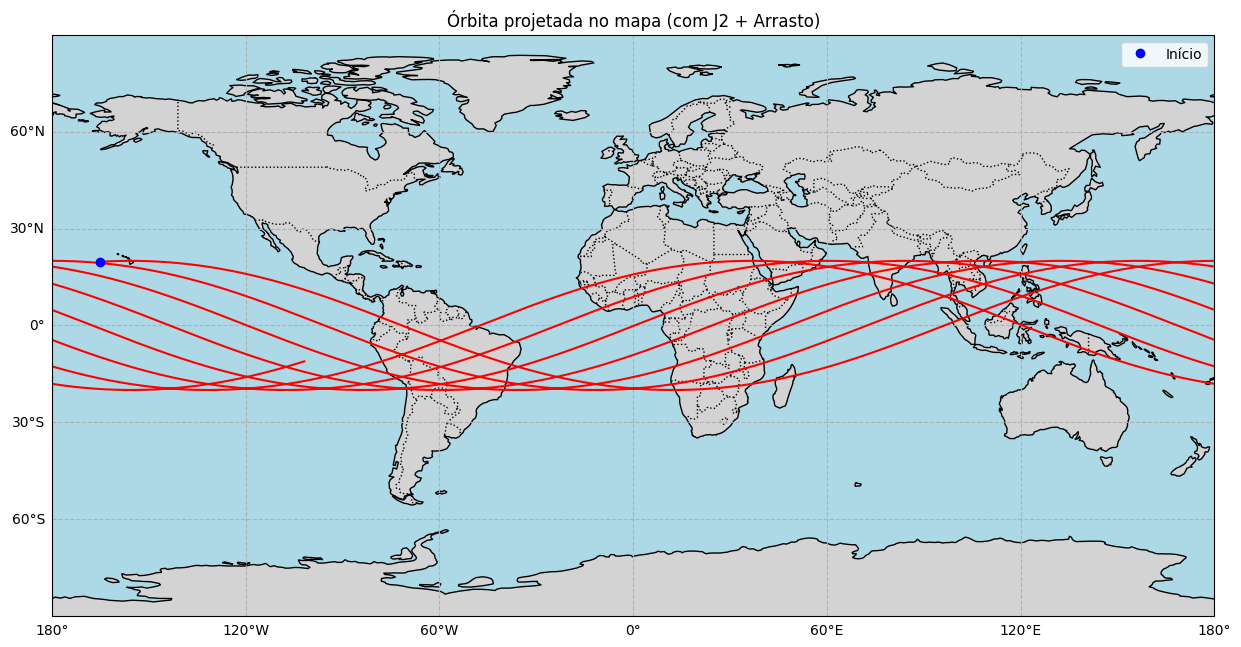

In [ ]:
#atual graph
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ... [O resto do seu código original permanece igual até a integração RK4] ...

# Função para converter ECEF para latitude/longitude
def ecef_to_lla(r_ecef):
    """Converte ECEF para latitude, longitude e altitude."""
    x, y, z = r_ecef
    longitude = np.arctan2(y, x)
    latitude = np.arctan2(z, np.sqrt(x**2 + y**2))
    return np.degrees(latitude), np.degrees(longitude)

# Calcula todas as latitudes/longitudes
latitudes, longitudes = [], []
for k in range(N):
    lat, lon = ecef_to_lla(r_ecef[k])
    latitudes.append(lat)
    longitudes.append(lon)

# Função para segmentar em múltiplas curvas (evita linhas cortando o mapa)
def segment_orbit(lons, lats, threshold=90):
    segments = []
    current_segment = []

    for lon, lat in zip(lons, lats):
        if not current_segment:
            current_segment.append((lon, lat))
            continue

        delta_lon = abs(((lon - current_segment[-1][0]) + 180) % 360 - 180)
        if delta_lon > threshold:
            segments.append(current_segment)
            current_segment = []
        current_segment.append((lon, lat))

    if current_segment:
        segments.append(current_segment)

    return segments

orbit_segments = segment_orbit(longitudes, latitudes)

# Mapa
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False

for segment in orbit_segments:
    if len(segment) > 1:
        lons, lats = zip(*segment)
        ax.plot(lons, lats, 'r', transform=ccrs.Geodetic(), linewidth=1.5)

# Ponto inicial
ax.plot(longitudes[1], latitudes[1], 'bo', transform=ccrs.Geodetic(), label='Início')
plt.title('Órbita projetada no mapa (com J2 + Arrasto)')
plt.legend()
plt.show()

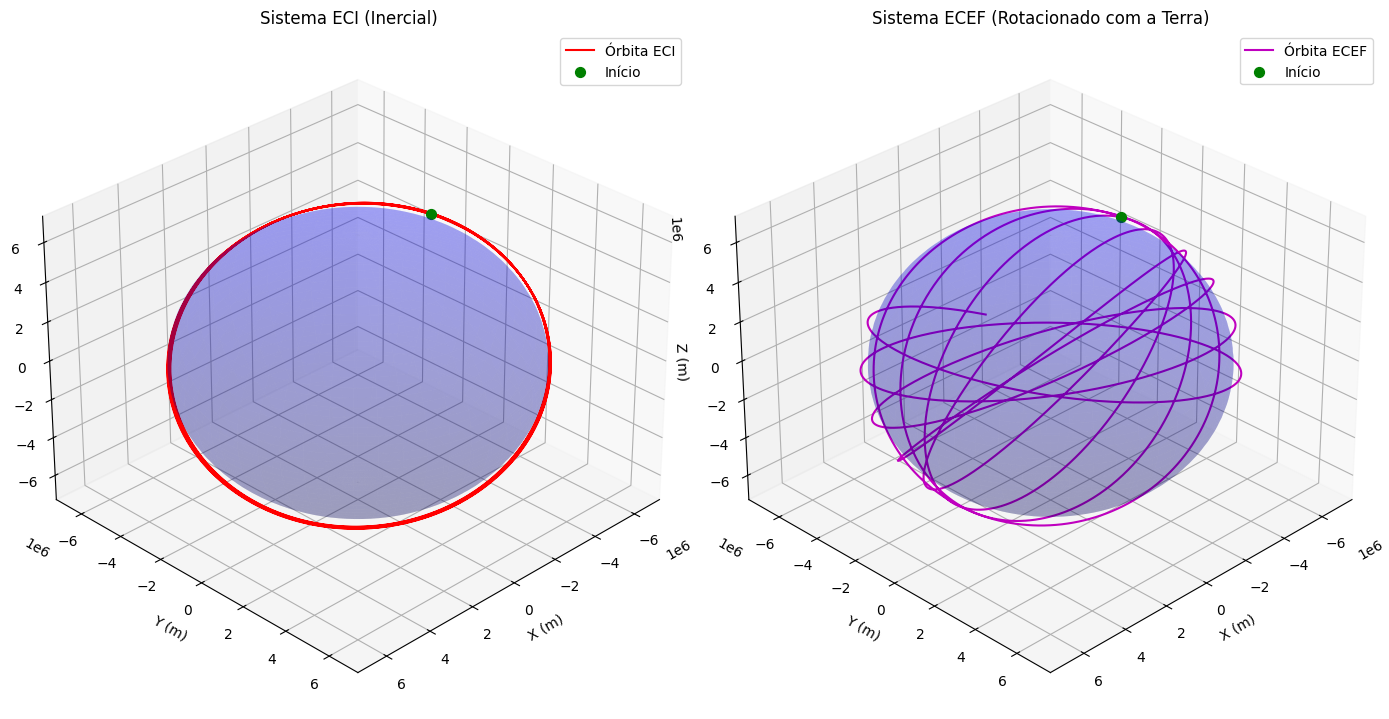

In [ ]:
#atual graph
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))

## Sistema ECI (Inercial) - Esquerda
ax1 = fig.add_subplot(121, projection='3d')

# Terra em ECI
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = R_terra * np.outer(np.cos(u), np.sin(v))
y = R_terra * np.outer(np.sin(u), np.sin(v))
z = R_terra * np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_surface(x, y, z, color='blue', alpha=0.2)

# Órbita em ECI
ax1.plot(r_eci[:, 0], r_eci[:, 1], r_eci[:, 2], 'r-', linewidth=1.5, label='Órbita ECI')
ax1.scatter(r_eci[0, 0], r_eci[0, 1], r_eci[0, 2], color='green', s=50, label='Início')

ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('Sistema ECI (Inercial)')
ax1.legend()
ax1.view_init(elev=30, azim=45)

## Sistema ECEF (Rotacionado) - Direita
ax2 = fig.add_subplot(122, projection='3d')

# Terra em ECEF (idêntica visualmente, mas o referencial gira)
ax2.plot_surface(x, y, z, color='blue', alpha=0.2)

# Órbita em ECEF (convertida)
ax2.plot(r_ecef[:, 0], r_ecef[:, 1], r_ecef[:, 2], 'm-', linewidth=1.5, label='Órbita ECEF')
ax2.scatter(r_ecef[0, 0], r_ecef[0, 1], r_ecef[0, 2], color='green', s=50, label='Início')

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Z (m)')
ax2.set_title('Sistema ECEF (Rotacionado com a Terra)')
ax2.legend()
ax2.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

------------
#Com PD

In [ ]:
#atual (simulação de atitude)
import numpy as np
from astropy.coordinates import get_sun, ICRS
from astropy.time import Time
from astropy import units as u

# Constantes globais (exemplo - devem ser definidas adequadamente)
mu = 3.986004418e14  # Parâmetro gravitacional da Terra (m^3/s^2)
IB = np.diag([1000, 1000, 1000])  # Tensor de inércia (exemplo)
rho0 = 1.0e-12  # Densidade atmosférica (kg/m^3)
Cd = 2.2  # Coeficiente de arrasto
A = 1.0  # Área de referência (m^2)
r_cp_body = np.array([0.1, 0, 0])  # Centro de pressão no corpo (m)
r_srp_body = np.array([0.1, 0, 0])  # Ponto de aplicação SRP no corpo (m)

def quaternion_to_dcm(q):
    """Converte quaternion para matriz de cossenos diretores com proteção contra overflow"""
    q = np.asarray(q)
    q_norm = np.linalg.norm(q)
    if q_norm == 0:
        return np.identity(3)

    # Normaliza o quaternion para evitar overflow
    q_normalized = q / q_norm
    q0, q1, q2, q3 = q_normalized

    # Limita os valores para evitar overflow numérico
    q1_sq = np.clip(q1**2, -1e10, 1e10)
    q2_sq = np.clip(q2**2, -1e10, 1e10)
    q3_sq = np.clip(q3**2, -1e10, 1e10)

    return np.array([
        [1 - 2*(q2_sq + q3_sq),     2*(q1*q2 - q0*q3),     2*(q1*q3 + q0*q2)],
        [    2*(q1*q2 + q0*q3), 1 - 2*(q1_sq + q3_sq),     2*(q2*q3 - q0*q1)],
        [    2*(q1*q3 - q0*q2),     2*(q2*q3 + q0*q1), 1 - 2*(q1_sq + q2_sq)]
    ])

def torque_gravitacional(q, r_eci, I):
    """Calcula torque gravitacional com proteção contra divisão por zero"""
    C_bi = quaternion_to_dcm(q).T  # ECI -> body
    r_body = C_bi @ r_eci
    r_norm_sq = np.clip(np.sum(r_body**2), 1e-10, None)  # Evita divisão por zero
    factor = 3 * mu / (r_norm_sq ** 2.5)  # r_norm^5 = (r_norm_sq)^2.5
    return factor * np.cross(r_body, I @ r_body)

def torque_aero(q, v_rel_eci, rho, Cd, A, r_cp_body):
    """Calcula torque aerodinâmico com proteção contra overflow"""
    C_bi = quaternion_to_dcm(q).T
    v_rel_body = C_bi @ v_rel_eci
    v_norm_sq = np.clip(np.sum(v_rel_body**2), 0, 1e10)  # Limita a magnitude
    v_norm = np.sqrt(v_norm_sq)
    if v_norm < 1e-10:  # Evita divisão por zero
        return np.zeros(3)

    F_aero_body = -0.5 * rho * Cd * A * v_norm * v_rel_body
    return np.cross(r_cp_body, F_aero_body)

def torque_srp(q, r_sat_eci, r_sun_eci, A_srp, r_srp_body):
    """Calcula torque de radiação solar com proteção contra overflow"""
    P_srp = 4.5e-6  # N/m²
    delta_r = r_sat_eci - r_sun_eci
    delta_r_norm_sq = np.clip(np.sum(delta_r**2), 1e-10, None)  # Evita divisão por zero
    s_hat = delta_r / np.sqrt(delta_r_norm_sq)

    C_bi = quaternion_to_dcm(q).T
    s_body = C_bi @ s_hat
    F_srp_body = -P_srp * A_srp * s_body
    return np.cross(r_srp_body, F_srp_body)

def torque_controle(q, w):
    """Controlador PD com saturação para evitar torques excessivos"""
    Kp = np.array([0.3, 0.3, 0.2])  # ganhos para x, y, z
    Kd = np.array([1.5, 1.5, 1.0])  # ganhos para x, y, z

    # Quaternion desejado
    q_desired = np.array([1, 0, 0, 0])

    # Erro do vetor quaternion (parte vetorial q1, q2, q3)
    q_error = q[1:4] - q_desired[1:4]

    # Torque com ganhos por eixo
    torque = -Kp * q_error - Kd * w

    # Saturação
    max_torque = 1.0
    return np.clip(torque, -max_torque, max_torque)
    # Kp = 0.3
    # Kd = 1
    # q_desired = np.array([1, 0, 0, 0])

    # # Saturação dos termos de controle
    # torque = -Kp*(q[1:4] - q_desired[1:4]) - Kd*w
    # max_torque = 1.0  # Valor máximo permitido
    # return np.clip(torque, -max_torque, max_torque)

def get_sun_position(t):
    """Calcula a posição do Sol em coordenadas ECI com proteção contra overflow"""
    try:
        epoch = Time("2025-01-01 00:00:00", scale='utc') + t * u.second
        sun_pos = get_sun(epoch).transform_to(ICRS)

        # Verifica valores extremos
        x = np.clip(sun_pos.cartesian.x.value, -1e10, 1e10)
        y = np.clip(sun_pos.cartesian.y.value, -1e10, 1e10)
        z = np.clip(sun_pos.cartesian.z.value, -1e10, 1e10)
        dist = np.clip(sun_pos.distance.value, 1e-10, 1e10)

        # return np.array([x, y, z]) * dist * 1.496e11  # AU to meters
        return sun_pos.cartesian.xyz.to(u.meter).value

    except:
        return np.zeros(3)  # Retorna zero em caso de erro

def torque_total(q, w, r_eci, v_rel, r_sun_eci):
    """Soma os torques com proteção contra NaN/overflow"""
    try:
        tau_gg = torque_gravitacional(q, r_eci, IB)
        tau_aero = torque_aero(q, v_rel, rho0, Cd, A, r_cp_body)
        tau_srp = torque_srp(q, r_eci, r_sun_eci, A, r_srp_body)
        tau_controle = torque_controle(q, w)

        total = tau_gg + tau_aero + tau_srp + tau_controle
        return np.nan_to_num(total, nan=0.0, posinf=1e10, neginf=-1e10)
    except:
        return np.zeros(3)

def omega_matrix(w):
    """Matriz Omega para equação cinemática do quaternion"""
    wx, wy, wz = w
    return np.array([
        [0, -wx, -wy, -wz],
        [wx, 0, wz, -wy],
        [wy, -wz, 0, wx],
        [wz, wy, -wx, 0]
    ])

def atitude_dinamica(q, w, r_eci, v_rel, r_sun_eci):
    """Dinâmica de atitude com proteção contra valores extremos"""
    try:
        tau = torque_total(q, w, r_eci, v_rel, r_sun_eci)
        I_inv = np.linalg.inv(IB)
        dw_dt = I_inv @ (tau - np.cross(w, IB @ w))

        # Proteção contra NaN/overflow
        dw_dt = np.nan_to_num(dw_dt, nan=0.0, posinf=1e10, neginf=-1e10)

        dq_dt = 0.5 * omega_matrix(w) @ q
        dq_dt = np.nan_to_num(dq_dt, nan=0.0, posinf=1e10, neginf=-1e10)

        return dq_dt, dw_dt
    except:
        return np.zeros(4), np.zeros(3)

# Condições iniciais (exemplo)
r0_eci = np.array([7000e3, 0, 0])  # Posição inicial (m)
v0_eci = np.array([0, 7.5e3, 0])   # Velocidade inicial (m/s)
q = np.array([1.0, 0.0, 0.0, 0.0])  # Quaternion inicial
w = np.array([0.01, 0.01, 0.01])    # Velocidade angular inicial (rad/s)
omega_terra = np.array([0, 0, 7.292115e-5])  # Velocidade angular da Terra

q_history = np.zeros((N, 4))
w_history = np.zeros((N, 3))
torque_history = np.zeros((N, 3))
euler_angles = np.zeros((N, 3))

# Condições iniciais
q_history[0] = q
w_history[0] = w

t0 = 0
tf = 12 * 3600  # 12 horas
dt = 10
N = int((tf - t0) / dt)
t_array = np.linspace(t0, tf, N)

# Loop de simulação com proteção adicional
for k in range(1, N):
    try:

        # Atualiza posição e velocidade (simplificado - deveria usar equações de movimento orbital)
        r = r_eci[k, :]  # Simplificação - deveria ser atualizado
        v = v_eci[k, :]  # Simplificação - deveria ser atualizado

        # Calcula posição do Sol
        r_sun = get_sun_position(t_array[k])

        # Velocidade relativa
        v_rel = v - np.cross(omega_terra, r)

        # Dinâmica de atitude
        dq_dt, dw_dt = atitude_dinamica(q, w, r, v_rel, r_sun)

        # Integração com normalização do quaternion
        q = q + dq_dt * dt
        w = w + dw_dt * dt

        # Normalização robusta do quaternion
        q_norm = np.linalg.norm(q)
        if q_norm > 1e-10:
            q = q / q_norm
        else:
            q = np.array([1.0, 0.0, 0.0, 0.0])  # Reset se o quaternion ficar muito pequeno

        # Limita a velocidade angular para evitar valores extremos
        w = np.clip(w, -10.0, 10.0)

        q_history[k] = q
        w_history[k] = w
        torque_history[k] = torque_total(q, w, r, v_rel, r_sun)

        # Converte quaternion para ângulos de Euler (opcional)
        # Implementação simplificada - considere usar uma biblioteca como scipy.spatial.transform
        q0, q1, q2, q3 = q
        roll = np.arctan2(2*(q0*q1 + q2*q3), 1 - 2*(q1**2 + q2**2))
        pitch = np.arcsin(2*(q0*q2 - q3*q1))
        yaw = np.arctan2(2*(q0*q3 + q1*q2), 1 - 2*(q2**2 + q3**2))
        euler_angles[k] = np.degrees([roll, pitch, yaw])  # Converte para graus

    except Exception as e:
        print(f"Erro no passo {k}: {str(e)}")
        break

In [ ]:
#atual (simulação de atitude com RK4)
import numpy as np
from astropy.coordinates import get_sun, ICRS
from astropy.time import Time
from astropy import units as u



def quaternion_to_dcm(q):
    q = np.asarray(q)
    q_norm = np.linalg.norm(q)
    if q_norm == 0:
        return np.identity(3)
    q_normalized = q / q_norm
    q0, q1, q2, q3 = q_normalized
    q1_sq = np.clip(q1**2, -1e10, 1e10)
    q2_sq = np.clip(q2**2, -1e10, 1e10)
    q3_sq = np.clip(q3**2, -1e10, 1e10)
    return np.array([
        [1 - 2*(q2_sq + q3_sq),     2*(q1*q2 - q0*q3),     2*(q1*q3 + q0*q2)],
        [    2*(q1*q2 + q0*q3), 1 - 2*(q1_sq + q3_sq),     2*(q2*q3 - q0*q1)],
        [    2*(q1*q3 - q0*q2),     2*(q2*q3 + q0*q1), 1 - 2*(q1_sq + q2_sq)]
    ])

def torque_gravitacional(q, r_eci, I):
    C_bi = quaternion_to_dcm(q).T
    r_body = C_bi @ r_eci
    r_norm_sq = np.clip(np.sum(r_body**2), 1e-10, None)
    factor = 3 * mu / (r_norm_sq ** 2.5)
    return factor * np.cross(r_body, I @ r_body)

def torque_aero(q, v_rel_eci, rho, Cd, A, r_cp_body):
    C_bi = quaternion_to_dcm(q).T
    v_rel_body = C_bi @ v_rel_eci
    v_norm_sq = np.clip(np.sum(v_rel_body**2), 0, 1e10)
    v_norm = np.sqrt(v_norm_sq)
    if v_norm < 1e-10:
        return np.zeros(3)
    F_aero_body = -0.5 * rho * Cd * A * v_norm * v_rel_body
    return np.cross(r_cp_body, F_aero_body)

def torque_srp(q, r_sat_eci, r_sun_eci, A_srp, r_srp_body):
    P_srp = 4.5e-6
    delta_r = r_sat_eci - r_sun_eci
    delta_r_norm_sq = np.clip(np.sum(delta_r**2), 1e-10, None)
    s_hat = delta_r / np.sqrt(delta_r_norm_sq)
    C_bi = quaternion_to_dcm(q).T
    s_body = C_bi @ s_hat
    F_srp_body = -P_srp * A_srp * s_body
    return np.cross(r_srp_body, F_srp_body)

def torque_controle(q, w):
    Kp = np.array([0.3, 0.3, 0.2])
    Kd = np.array([1.5, 1.5, 1.0])
    q_desired = np.array([1, 0, 0, 0])
    q_error = q[1:4] - q_desired[1:4]
    torque = -Kp * q_error - Kd * w
    max_torque = 1.0
    return np.clip(torque, -max_torque, max_torque)

def get_sun_position(t):
    try:
        epoch = Time("2025-01-01 00:00:00", scale='utc') + t * u.second
        sun_pos = get_sun(epoch).transform_to(ICRS)
        return sun_pos.cartesian.xyz.to(u.meter).value
    except:
        return np.zeros(3)

def torque_total(q, w, r_eci, v_rel, r_sun_eci):
    try:
        tau_gg = torque_gravitacional(q, r_eci, IB)
        tau_aero = torque_aero(q, v_rel, rho0, Cd, A, r_cp_body)
        tau_srp = torque_srp(q, r_eci, r_sun_eci, A, r_srp_body)
        tau_controle = torque_controle(q, w)
        total = tau_gg + tau_aero + tau_srp + tau_controle
        return np.nan_to_num(total, nan=0.0, posinf=1e10, neginf=-1e10)
    except:
        return np.zeros(3)

def omega_matrix(w):
    wx, wy, wz = w
    return np.array([
        [0, -wx, -wy, -wz],
        [wx, 0, wz, -wy],
        [wy, -wz, 0, wx],
        [wz, wy, -wx, 0]
    ])

def atitude_dinamica(q, w, r_eci, v_rel, r_sun_eci):
    try:
        tau = torque_total(q, w, r_eci, v_rel, r_sun_eci)
        I_inv = np.linalg.inv(IB)
        dw_dt = I_inv @ (tau - np.cross(w, IB @ w))
        dw_dt = np.nan_to_num(dw_dt, nan=0.0, posinf=1e10, neginf=-1e10)
        dq_dt = 0.5 * omega_matrix(w) @ q
        dq_dt = np.nan_to_num(dq_dt, nan=0.0, posinf=1e10, neginf=-1e10)
        return dq_dt, dw_dt
    except:
        return np.zeros(4), np.zeros(3)

def rk4_attitude_step(q, w, dt, r, v_rel, r_sun):
    def f(qi, wi):
        return atitude_dinamica(qi, wi, r, v_rel, r_sun)
    k1_q, k1_w = f(q, w)
    k2_q, k2_w = f(q + 0.5 * dt * k1_q, w + 0.5 * dt * k1_w)
    k3_q, k3_w = f(q + 0.5 * dt * k2_q, w + 0.5 * dt * k2_w)
    k4_q, k4_w = f(q + dt * k3_q, w + dt * k3_w)
    q_new = q + (dt / 6.0) * (k1_q + 2*k2_q + 2*k3_q + k4_q)
    w_new = w + (dt / 6.0) * (k1_w + 2*k2_w + 2*k3_w + k4_w)
    return q_new, w_new

# Simulação

omega_terra = np.array([0, 0, 7.292115e-5])
q = np.array([1.0, 0.0, 0.0, 0.0])
w = np.array([0.01, 0.01, 0.01])
t0 = 0
tf = 12 * 3600
dt = 10
N = int((tf - t0) / dt)
t_array = np.linspace(t0, tf, N)
q_history = np.zeros((N, 4))
w_history = np.zeros((N, 3))
torque_history = np.zeros((N, 3))
euler_angles = np.zeros((N, 3))

q_history[0] = q
w_history[0] = w

for k in range(1, N):
    try:
        r = r_eci[k, :]
        v = v_eci[k, :]
        r_sun = get_sun_position(t_array[k])
        v_rel = v - np.cross(omega_terra, r)
        q, w = rk4_attitude_step(q, w, dt, r, v_rel, r_sun)
        q_norm = np.linalg.norm(q)
        if q_norm > 1e-10:
            q = q / q_norm
        else:
            q = np.array([1.0, 0.0, 0.0, 0.0])
        w = np.clip(w, -10.0, 10.0)
        q_history[k] = q
        w_history[k] = w
        torque_history[k] = torque_total(q, w, r, v_rel, r_sun)
        q0, q1, q2, q3 = q
        roll = np.arctan2(2*(q0*q1 + q2*q3), 1 - 2*(q1**2 + q2**2))
        pitch = np.arcsin(2*(q0*q2 - q3*q1))
        yaw = np.arctan2(2*(q0*q3 + q1*q2), 1 - 2*(q2**2 + q3**2))
        euler_angles[k] = np.degrees([roll, pitch, yaw])
    except Exception as e:
        print(f"Erro no passo {k}: {str(e)}")
        break


Erro no passo 1: name 'r_eci' is not defined


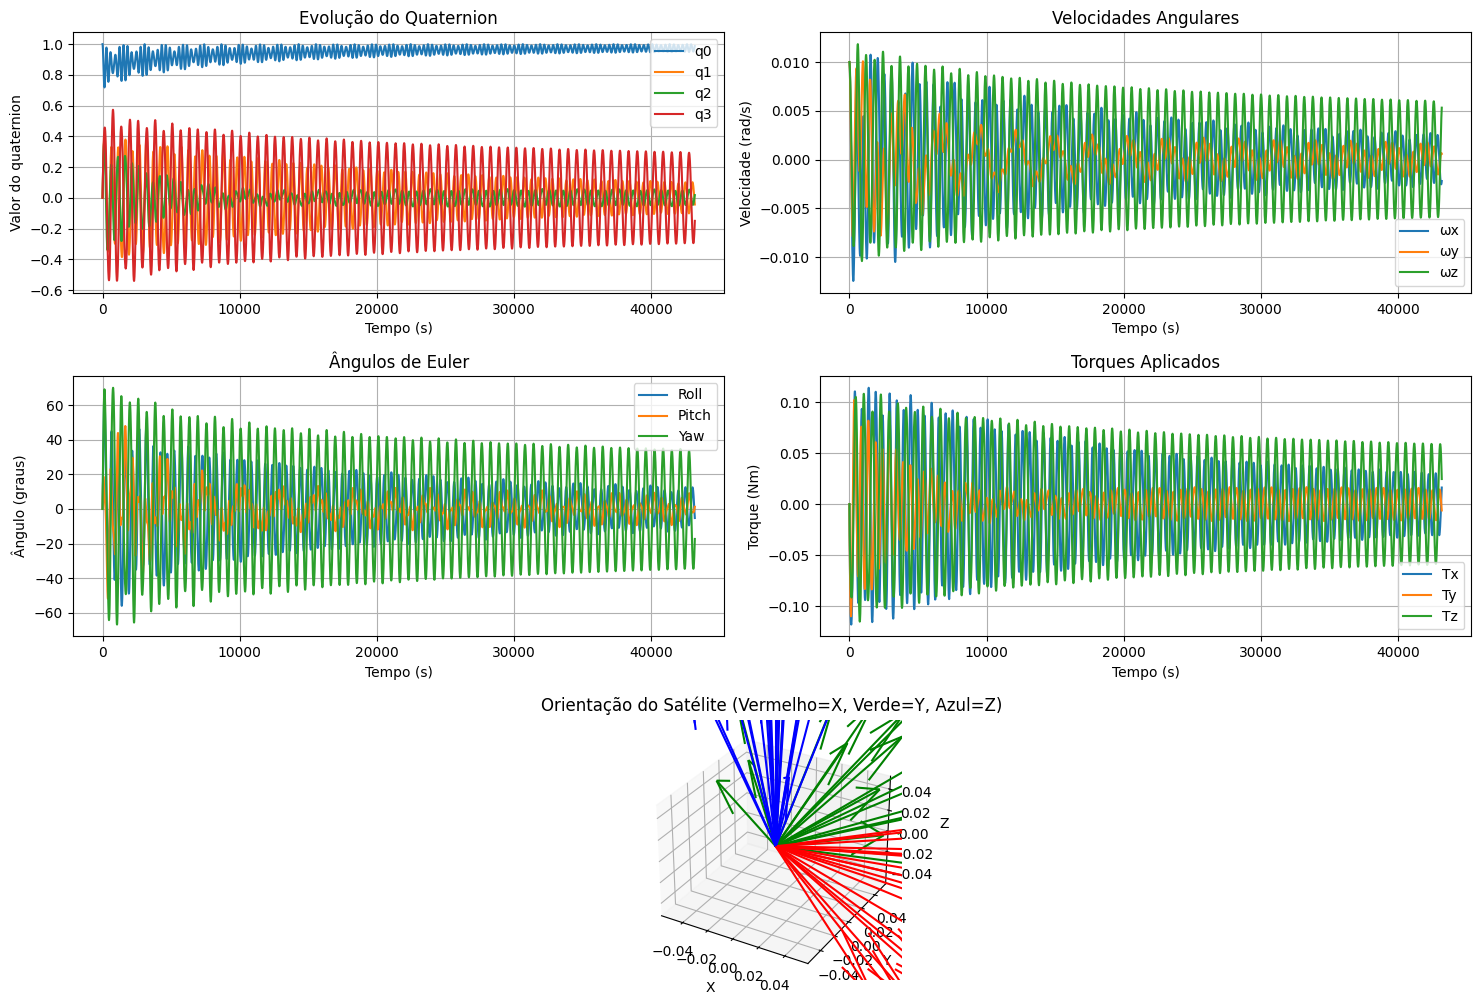

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def quaternion_to_dcm(q):
    q0, q1, q2, q3 = q
    return np.array([
        [1 - 2*(q2**2 + q3**2), 2*(q1*q2 - q0*q3), 2*(q1*q3 + q0*q2)],
        [2*(q1*q2 + q0*q3), 1 - 2*(q1**2 + q3**2), 2*(q2*q3 - q0*q1)],
        [2*(q1*q3 - q0*q2), 2*(q2*q3 + q0*q1), 1 - 2*(q1**2 + q2**2)]
    ])

# Gráficos
fig = plt.figure(figsize=(15, 10))

# 1. Evolução dos componentes do quaternion
ax1 = fig.add_subplot(3, 2, 1)
ax1.plot(t_array, q_history[:, 0], label='q0')
ax1.plot(t_array, q_history[:, 1], label='q1')
ax1.plot(t_array, q_history[:, 2], label='q2')
ax1.plot(t_array, q_history[:, 3], label='q3')
ax1.set_title('Evolução do Quaternion')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Valor do quaternion')
ax1.legend()
ax1.grid(True)

# 2. Velocidades angulares
ax2 = fig.add_subplot(3, 2, 2)
ax2.plot(t_array, w_history[:, 0], label='ωx')
ax2.plot(t_array, w_history[:, 1], label='ωy')
ax2.plot(t_array, w_history[:, 2], label='ωz')
ax2.set_title('Velocidades Angulares')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade (rad/s)')
ax2.legend()
ax2.grid(True)

# 3. Ângulos de Euler
ax3 = fig.add_subplot(3, 2, 3)
ax3.plot(t_array, euler_angles[:, 0], label='Roll')
ax3.plot(t_array, euler_angles[:, 1], label='Pitch')
ax3.plot(t_array, euler_angles[:, 2], label='Yaw')
ax3.set_title('Ângulos de Euler')
ax3.set_xlabel('Tempo (s)')
ax3.set_ylabel('Ângulo (graus)')
ax3.legend()
ax3.grid(True)

# 4. Componentes do torque
ax4 = fig.add_subplot(3, 2, 4)
ax4.plot(t_array, torque_history[:, 0], label='Tx')
ax4.plot(t_array, torque_history[:, 1], label='Ty')
ax4.plot(t_array, torque_history[:, 2], label='Tz')
ax4.set_title('Torques Aplicados')
ax4.set_xlabel('Tempo (s)')
ax4.set_ylabel('Torque (Nm)')
ax4.legend()
ax4.grid(True)

# 5. Trajetória da atitude (3D)
ax5 = fig.add_subplot(3, 2, (5, 6), projection='3d')
x_axis = np.array([quaternion_to_dcm(q) @ np.array([1, 0, 0]) for q in q_history])
y_axis = np.array([quaternion_to_dcm(q) @ np.array([0, 1, 0]) for q in q_history])
z_axis = np.array([quaternion_to_dcm(q) @ np.array([0, 0, 1]) for q in q_history])

step = N // 20
for i in range(0, N, step):
    ax5.quiver(0, 0, 0, x_axis[i, 0], x_axis[i, 1], x_axis[i, 2], color='r', length=0.2, normalize=True)
    ax5.quiver(0, 0, 0, y_axis[i, 0], y_axis[i, 1], y_axis[i, 2], color='g', length=0.2, normalize=True)
    ax5.quiver(0, 0, 0, z_axis[i, 0], z_axis[i, 1], z_axis[i, 2], color='b', length=0.2, normalize=True)

ax5.set_title('Orientação do Satélite (Vermelho=X, Verde=Y, Azul=Z)')
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.set_zlabel('Z')

fig.tight_layout()
plt.show()


--------------------------

#Com B-dot


In [ ]:
#atual (simulação de atitude)
import numpy as np
from astropy.coordinates import get_sun, ICRS
from astropy.time import Time
from astropy import units as u

# Constantes globais (exemplo - devem ser definidas adequadamente)
mu = 3.986004418e14  # Parâmetro gravitacional da Terra (m^3/s^2)
IB = np.diag([1000, 1000, 1000])  # Tensor de inércia (exemplo)
rho0 = 1.0e-12  # Densidade atmosférica (kg/m^3)
Cd = 2.2  # Coeficiente de arrasto
A = 1.0  # Área de referência (m^2)
r_cp_body = np.array([0.1, 0, 0])  # Centro de pressão no corpo (m)
r_srp_body = np.array([0.1, 0, 0])  # Ponto de aplicação SRP no corpo (m)

def quaternion_to_dcm(q):
    """Converte quaternion para matriz de cossenos diretores com proteção contra overflow"""
    q = np.asarray(q)
    q_norm = np.linalg.norm(q)
    if q_norm == 0:
        return np.identity(3)

    # Normaliza o quaternion para evitar overflow
    q_normalized = q / q_norm
    q0, q1, q2, q3 = q_normalized

    # Limita os valores para evitar overflow numérico
    q1_sq = np.clip(q1**2, -1e10, 1e10)
    q2_sq = np.clip(q2**2, -1e10, 1e10)
    q3_sq = np.clip(q3**2, -1e10, 1e10)

    return np.array([
        [1 - 2*(q2_sq + q3_sq),     2*(q1*q2 - q0*q3),     2*(q1*q3 + q0*q2)],
        [    2*(q1*q2 + q0*q3), 1 - 2*(q1_sq + q3_sq),     2*(q2*q3 - q0*q1)],
        [    2*(q1*q3 - q0*q2),     2*(q2*q3 + q0*q1), 1 - 2*(q1_sq + q2_sq)]
    ])

def torque_gravitacional(q, r_eci, I):
    """Calcula torque gravitacional com proteção contra divisão por zero"""
    C_bi = quaternion_to_dcm(q).T  # ECI -> body
    r_body = C_bi @ r_eci
    r_norm_sq = np.clip(np.sum(r_body**2), 1e-10, None)  # Evita divisão por zero
    factor = 3 * mu / (r_norm_sq ** 2.5)  # r_norm^5 = (r_norm_sq)^2.5
    return factor * np.cross(r_body, I @ r_body)

def torque_aero(q, v_rel_eci, rho, Cd, A, r_cp_body):
    """Calcula torque aerodinâmico com proteção contra overflow"""
    C_bi = quaternion_to_dcm(q).T
    v_rel_body = C_bi @ v_rel_eci
    v_norm_sq = np.clip(np.sum(v_rel_body**2), 0, 1e10)  # Limita a magnitude
    v_norm = np.sqrt(v_norm_sq)
    if v_norm < 1e-10:  # Evita divisão por zero
        return np.zeros(3)

    F_aero_body = -0.5 * rho * Cd * A * v_norm * v_rel_body
    return np.cross(r_cp_body, F_aero_body)

def torque_srp(q, r_sat_eci, r_sun_eci, A_srp, r_srp_body):
    """Calcula torque de radiação solar com proteção contra overflow"""
    P_srp = 4.5e-6  # N/m²
    delta_r = r_sat_eci - r_sun_eci
    delta_r_norm_sq = np.clip(np.sum(delta_r**2), 1e-10, None)  # Evita divisão por zero
    s_hat = delta_r / np.sqrt(delta_r_norm_sq)

    C_bi = quaternion_to_dcm(q).T
    s_body = C_bi @ s_hat
    F_srp_body = -P_srp * A_srp * s_body
    return np.cross(r_srp_body, F_srp_body)

def campo_magnetico_dipolo(r_eci):
    """
    Calcula o campo magnético da Terra (modelo de dipolo) em um ponto r_eci [m]
    :param r_eci: vetor posição do satélite em metros (ECI)
    :return: campo magnético B em Tesla
    """
    mu0 = 4 * np.pi * 1e-7  # permeabilidade do vácuo [H/m]

    # Momento magnético da Terra (aproximado)
    M = np.array([0, 0, 7.96e22])  # [A·m²] (alinhado com o eixo Z geocêntrico)

    r = np.linalg.norm(r_eci)
    r_hat = r_eci / r

    fator = mu0 / (4 * np.pi * r**3)

    B = fator * (3 * r_hat * np.dot(M, r_hat) - M)
    return B

def torque_controle(q, w, B_eci):
    """
    Controlador B-dot: gera torque com base na velocidade angular e campo magnético.
    q     : quaternion atual (para rotação de ECI → corpo)
    w     : velocidade angular no referencial do corpo [rad/s]
    B_eci : vetor do campo magnético na base inercial (ECI) [Tesla]
    """
    # Ganho do controle B-dot (ajustável)
    k_bdot = 1e5  # experimente valores entre 1e4 e 1e6

    # Converte quaternion para matriz de rotação: corpo <- inercial
    R = quaternion_to_dcm(q)  # você deve já ter essa função
    B_body = R @ B_eci  # campo magnético no referencial do corpo

    # Calcula momento magnético m = k_bdot * (w × B)
    m = k_bdot * np.cross(w, B_body)

    # Torque = m × B
    torque = np.cross(m, B_body)

    # Saturação opcional
    max_torque = 1.0  # Nm
    return np.clip(torque, -max_torque, max_torque)

# def torque_controle(q, w):
#     """Controlador PD com saturação para evitar torques excessivos"""
#     Kp = np.array([0.3, 0.3, 0.2])  # ganhos para x, y, z
#     Kd = np.array([1.5, 1.5, 1.0])  # ganhos para x, y, z

#     # Quaternion desejado
#     q_desired = np.array([1, 0, 0, 0])

#     # Erro do vetor quaternion (parte vetorial q1, q2, q3)
#     q_error = q[1:4] - q_desired[1:4]

#     # Torque com ganhos por eixo
#     torque = -Kp * q_error - Kd * w

#     # Saturação
#     max_torque = 1.0
#     return np.clip(torque, -max_torque, max_torque)
#     # Kp = 0.3
#     # Kd = 1
#     # q_desired = np.array([1, 0, 0, 0])

#     # # Saturação dos termos de controle
#     # torque = -Kp*(q[1:4] - q_desired[1:4]) - Kd*w
#     # max_torque = 1.0  # Valor máximo permitido
#     # return np.clip(torque, -max_torque, max_torque)

def get_sun_position(t):
    """Calcula a posição do Sol em coordenadas ECI com proteção contra overflow"""
    try:
        epoch = Time("2025-01-01 00:00:00", scale='utc') + t * u.second
        sun_pos = get_sun(epoch).transform_to(ICRS)

        # Verifica valores extremos
        x = np.clip(sun_pos.cartesian.x.value, -1e10, 1e10)
        y = np.clip(sun_pos.cartesian.y.value, -1e10, 1e10)
        z = np.clip(sun_pos.cartesian.z.value, -1e10, 1e10)
        dist = np.clip(sun_pos.distance.value, 1e-10, 1e10)

        # return np.array([x, y, z]) * dist * 1.496e11  # AU to meters
        return sun_pos.cartesian.xyz.to(u.meter).value

    except:
        return np.zeros(3)  # Retorna zero em caso de erro

def torque_total(q, w, r_eci, v_rel, r_sun_eci):
    """Soma os torques com proteção contra NaN/overflow"""
    try:
        tau_gg = torque_gravitacional(q, r_eci, IB)
        tau_aero = torque_aero(q, v_rel, rho0, Cd, A, r_cp_body)
        tau_srp = torque_srp(q, r_eci, r_sun_eci, A, r_srp_body)
        B_eci = campo_magnetico_dipolo(r_eci)
        tau_controle = torque_controle(q, w, B_eci)

        total = tau_gg + tau_aero + tau_srp + tau_controle
        return np.nan_to_num(total, nan=0.0, posinf=1e10, neginf=-1e10)
    except:
        return np.zeros(3)

def omega_matrix(w):
    """Matriz Omega para equação cinemática do quaternion"""
    wx, wy, wz = w
    return np.array([
        [0, -wx, -wy, -wz],
        [wx, 0, wz, -wy],
        [wy, -wz, 0, wx],
        [wz, wy, -wx, 0]
    ])

def atitude_dinamica(q, w, r_eci, v_rel, r_sun_eci):
    """Dinâmica de atitude com proteção contra valores extremos"""
    try:
        tau = torque_total(q, w, r_eci, v_rel, r_sun_eci)
        I_inv = np.linalg.inv(IB)
        dw_dt = I_inv @ (tau - np.cross(w, IB @ w))

        # Proteção contra NaN/overflow
        dw_dt = np.nan_to_num(dw_dt, nan=0.0, posinf=1e10, neginf=-1e10)

        dq_dt = 0.5 * omega_matrix(w) @ q
        dq_dt = np.nan_to_num(dq_dt, nan=0.0, posinf=1e10, neginf=-1e10)

        return dq_dt, dw_dt
    except:
        return np.zeros(4), np.zeros(3)

# Condições iniciais (exemplo)
r0_eci = np.array([7000e3, 0, 0])  # Posição inicial (m)
v0_eci = np.array([0, 7.5e3, 0])   # Velocidade inicial (m/s)
q = np.array([1.0, 0.0, 0.0, 0.0])  # Quaternion inicial
w = np.array([0.01, 0.01, 0.01])    # Velocidade angular inicial (rad/s)
omega_terra = np.array([0, 0, 7.292115e-5])  # Velocidade angular da Terra

q_history = np.zeros((N, 4))
w_history = np.zeros((N, 3))
torque_history = np.zeros((N, 3))
euler_angles = np.zeros((N, 3))

# Condições iniciais
q_history[0] = q
w_history[0] = w

t0 = 0
tf = 12 * 3600  # 12 horas
dt = 10
N = int((tf - t0) / dt)
t_array = np.linspace(t0, tf, N)

# Loop de simulação com proteção adicional
for k in range(1, N):
    try:

        # Atualiza posição e velocidade (simplificado - deveria usar equações de movimento orbital)
        r = r_eci[k, :]  # Simplificação - deveria ser atualizado
        v = v_eci[k, :]  # Simplificação - deveria ser atualizado

        # Calcula posição do Sol
        r_sun = get_sun_position(t_array[k])

        # Velocidade relativa
        v_rel = v - np.cross(omega_terra, r)

        # Dinâmica de atitude
        dq_dt, dw_dt = atitude_dinamica(q, w, r, v_rel, r_sun)

        # Integração com normalização do quaternion
        q = q + dq_dt * dt
        w = w + dw_dt * dt

        # Normalização robusta do quaternion
        q_norm = np.linalg.norm(q)
        if q_norm > 1e-10:
            q = q / q_norm
        else:
            q = np.array([1.0, 0.0, 0.0, 0.0])  # Reset se o quaternion ficar muito pequeno

        # Limita a velocidade angular para evitar valores extremos
        w = np.clip(w, -10.0, 10.0)

        q_history[k] = q
        w_history[k] = w
        torque_history[k] = torque_total(q, w, r, v_rel, r_sun)

        # Converte quaternion para ângulos de Euler (opcional)
        # Implementação simplificada - considere usar uma biblioteca como scipy.spatial.transform
        q0, q1, q2, q3 = q
        roll = np.arctan2(2*(q0*q1 + q2*q3), 1 - 2*(q1**2 + q2**2))
        pitch = np.arcsin(2*(q0*q2 - q3*q1))
        yaw = np.arctan2(2*(q0*q3 + q1*q2), 1 - 2*(q2**2 + q3**2))
        euler_angles[k] = np.degrees([roll, pitch, yaw])  # Converte para graus

    except Exception as e:
        print(f"Erro no passo {k}: {str(e)}")
        break

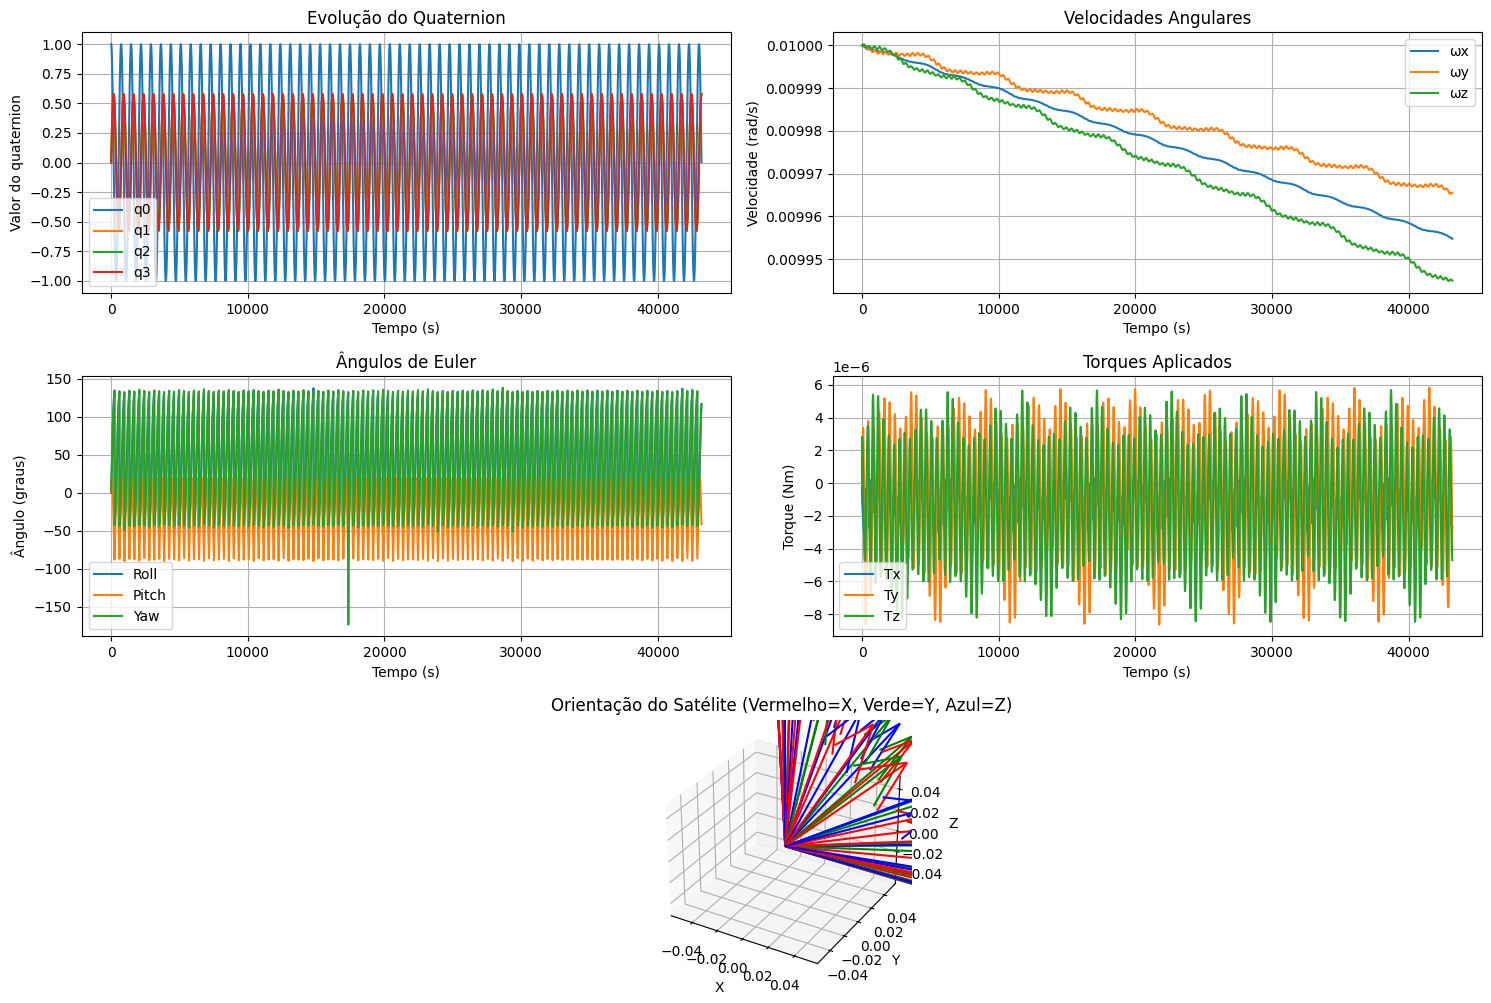

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def quaternion_to_dcm(q):
    q0, q1, q2, q3 = q
    return np.array([
        [1 - 2*(q2**2 + q3**2), 2*(q1*q2 - q0*q3), 2*(q1*q3 + q0*q2)],
        [2*(q1*q2 + q0*q3), 1 - 2*(q1**2 + q3**2), 2*(q2*q3 - q0*q1)],
        [2*(q1*q3 - q0*q2), 2*(q2*q3 + q0*q1), 1 - 2*(q1**2 + q2**2)]
    ])

# Gráficos
fig = plt.figure(figsize=(15, 10))

# 1. Evolução dos componentes do quaternion
ax1 = fig.add_subplot(3, 2, 1)
ax1.plot(t_array, q_history[:, 0], label='q0')
ax1.plot(t_array, q_history[:, 1], label='q1')
ax1.plot(t_array, q_history[:, 2], label='q2')
ax1.plot(t_array, q_history[:, 3], label='q3')
ax1.set_title('Evolução do Quaternion')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Valor do quaternion')
ax1.legend()
ax1.grid(True)

# 2. Velocidades angulares
ax2 = fig.add_subplot(3, 2, 2)
ax2.plot(t_array, w_history[:, 0], label='ωx')
ax2.plot(t_array, w_history[:, 1], label='ωy')
ax2.plot(t_array, w_history[:, 2], label='ωz')
ax2.set_title('Velocidades Angulares')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade (rad/s)')
ax2.legend()
ax2.grid(True)

# 3. Ângulos de Euler
ax3 = fig.add_subplot(3, 2, 3)
ax3.plot(t_array, euler_angles[:, 0], label='Roll')
ax3.plot(t_array, euler_angles[:, 1], label='Pitch')
ax3.plot(t_array, euler_angles[:, 2], label='Yaw')
ax3.set_title('Ângulos de Euler')
ax3.set_xlabel('Tempo (s)')
ax3.set_ylabel('Ângulo (graus)')
ax3.legend()
ax3.grid(True)

# 4. Componentes do torque
ax4 = fig.add_subplot(3, 2, 4)
ax4.plot(t_array, torque_history[:, 0], label='Tx')
ax4.plot(t_array, torque_history[:, 1], label='Ty')
ax4.plot(t_array, torque_history[:, 2], label='Tz')
ax4.set_title('Torques Aplicados')
ax4.set_xlabel('Tempo (s)')
ax4.set_ylabel('Torque (Nm)')
ax4.legend()
ax4.grid(True)

# 5. Trajetória da atitude (3D)
ax5 = fig.add_subplot(3, 2, (5, 6), projection='3d')
x_axis = np.array([quaternion_to_dcm(q) @ np.array([1, 0, 0]) for q in q_history])
y_axis = np.array([quaternion_to_dcm(q) @ np.array([0, 1, 0]) for q in q_history])
z_axis = np.array([quaternion_to_dcm(q) @ np.array([0, 0, 1]) for q in q_history])

step = N // 20
for i in range(0, N, step):
    ax5.quiver(0, 0, 0, x_axis[i, 0], x_axis[i, 1], x_axis[i, 2], color='r', length=0.2, normalize=True)
    ax5.quiver(0, 0, 0, y_axis[i, 0], y_axis[i, 1], y_axis[i, 2], color='g', length=0.2, normalize=True)
    ax5.quiver(0, 0, 0, z_axis[i, 0], z_axis[i, 1], z_axis[i, 2], color='b', length=0.2, normalize=True)

ax5.set_title('Orientação do Satélite (Vermelho=X, Verde=Y, Azul=Z)')
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.set_zlabel('Z')

fig.tight_layout()
plt.show()


-- fim --

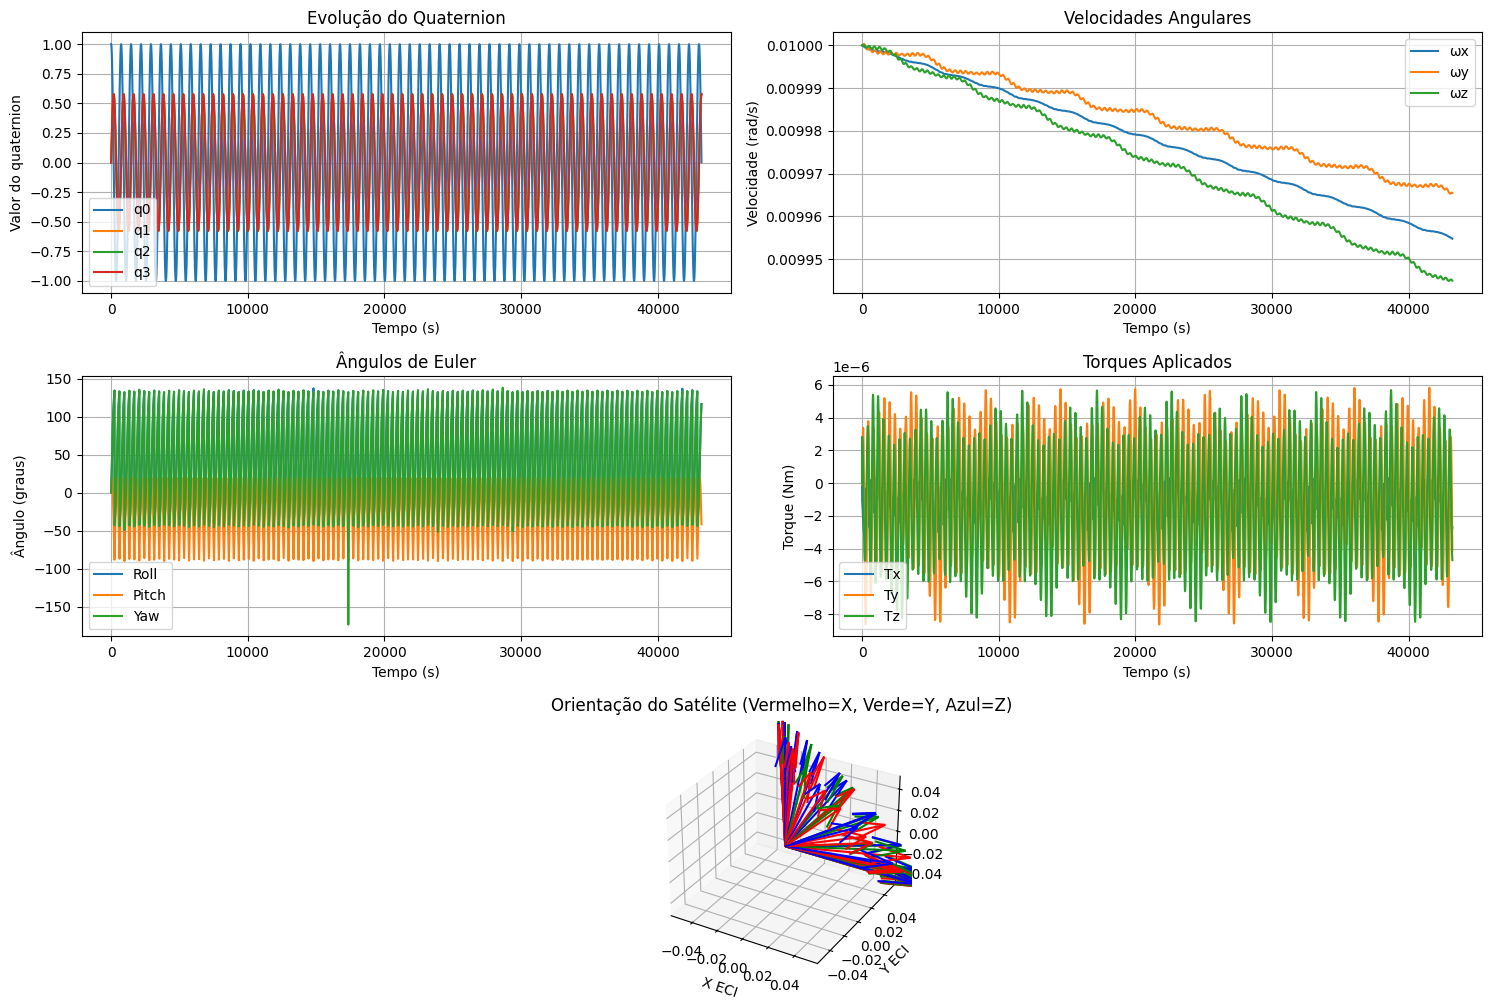

In [ ]:
#atual mas provavelmente ta errado
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Configuração dos plots
plt.figure(figsize=(15, 10))

# 1. Evolução dos componentes do quaternion
plt.subplot(3, 2, 1)
plt.plot(t_array, q_history[:, 0], label='q0')
plt.plot(t_array, q_history[:, 1], label='q1')
plt.plot(t_array, q_history[:, 2], label='q2')
plt.plot(t_array, q_history[:, 3], label='q3')
plt.title('Evolução do Quaternion')
plt.xlabel('Tempo (s)')
plt.ylabel('Valor do quaternion')
plt.legend()
plt.grid(True)

# 2. Velocidades angulares
plt.subplot(3, 2, 2)
plt.plot(t_array, w_history[:, 0], label='ωx')
plt.plot(t_array, w_history[:, 1], label='ωy')
plt.plot(t_array, w_history[:, 2], label='ωz')
plt.title('Velocidades Angulares')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade (rad/s)')
plt.legend()
plt.grid(True)

# 3. Ângulos de Euler
plt.subplot(3, 2, 3)
plt.plot(t_array, euler_angles[:, 0], label='Roll')
plt.plot(t_array, euler_angles[:, 1], label='Pitch')
plt.plot(t_array, euler_angles[:, 2], label='Yaw')
plt.title('Ângulos de Euler')
plt.xlabel('Tempo (s)')
plt.ylabel('Ângulo (graus)')
plt.legend()
plt.grid(True)

# 4. Componentes do torque
plt.subplot(3, 2, 4)
plt.plot(t_array, torque_history[:, 0], label='Tx')
plt.plot(t_array, torque_history[:, 1], label='Ty')
plt.plot(t_array, torque_history[:, 2], label='Tz')
plt.title('Torques Aplicados')
plt.xlabel('Tempo (s)')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid(True)

# 5. Trajetória da atitude (3D)
plt.subplot(3, 2, (5,6), projection='3d')
# Calcula vetores de eixo do corpo ao longo do tempo
x_axis = np.array([quaternion_to_dcm(q) @ np.array([1,0,0]) for q in q_history])
y_axis = np.array([quaternion_to_dcm(q) @ np.array([0,1,0]) for q in q_history])
z_axis = np.array([quaternion_to_dcm(q) @ np.array([0,0,1]) for q in q_history])

# Plota apenas alguns pontos para clareza
step = N//20
for i in range(0, N, step):
    plt.quiver(0, 0, 0, x_axis[i,0], x_axis[i,1], x_axis[i,2], color='r', length=0.1)
    plt.quiver(0, 0, 0, y_axis[i,0], y_axis[i,1], y_axis[i,2], color='g', length=0.1)
    plt.quiver(0, 0, 0, z_axis[i,0], z_axis[i,1], z_axis[i,2], color='b', length=0.1)

plt.title('Orientação do Satélite (Vermelho=X, Verde=Y, Azul=Z)')
plt.xlabel('X ECI')
plt.ylabel('Y ECI')
plt.tight_layout()

plt.show()